In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from tqdm import tqdm
#from sklearn_extra.cluster import CLARA
from scipy.signal import welch

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### Lectura de archivos

In [3]:
ocean_beach = pd.read_csv('../data/ocean/Australia/Torbay01.wst', sep='\s+', header=None)
torbay = pd.read_csv('../data/ocean/Australia/OBDEP01.wst', sep='\s+', header=None)

<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_3373003/457389057.py:1: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_3373003/457389057.py:2: SyntaxWarning:

invalid escape sequence '\s'



In [4]:
ocean_beach

,0,1,2,3
0,1,1,1.997,0.0
1,1,2,1.963,0.0
2,1,3,1.815,0.0
3,1,4,1.631,0.0
4,1,5,1.171,0.0
...,...,...,...,...
7771195,1619,4796,32.809,0.0
7771196,1619,4797,32.553,0.0
7771197,1619,4798,32.270,0.0
7771198,1619,4799,32.045,0.0


### Visualización fragmento serie temporal

#### Ocean beach

(4800, 4)

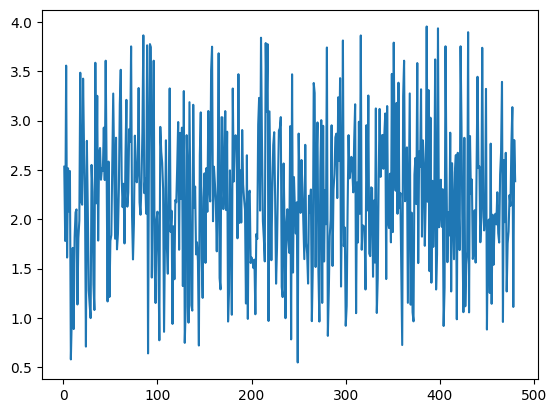

In [5]:
o1 = ocean_beach[ocean_beach[0] == 2]
plt.plot(o1[1][:480], o1[2][:480])
ocean_beach[ocean_beach[0] == 1].shape


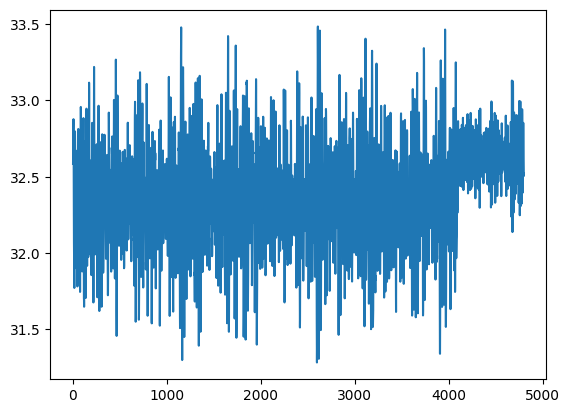

In [6]:
o2 = ocean_beach[ocean_beach[0] == 17]
plt.plot(o2[1], o2[2])

#### Torbay

/tmp/ipykernel_3373003/1965963464.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



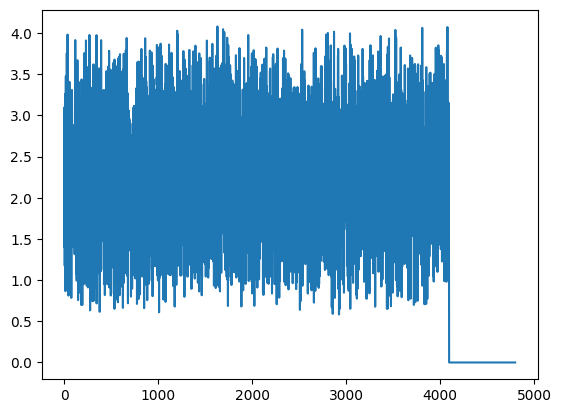

In [7]:
o1 = torbay[ocean_beach[0] == 2]
plt.plot(o1[1], o1[2])

/tmp/ipykernel_3373003/2689900452.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



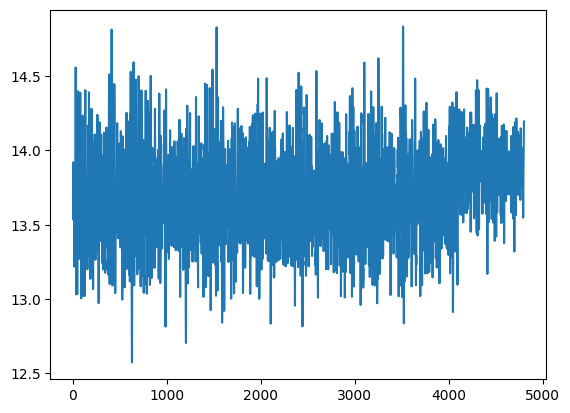

In [8]:
o2 = torbay[ocean_beach[0] == 17]
plt.plot(o2[1], o2[2])

### Creación del archivo de espectro de energía

In [9]:
def crear_espectro_ssh():
    # SET PARAMETERS
    Fs = 2  # Sampling frequency (Hz)
    T = 1 / Fs  # Sampling period (s)
    L = 4800  # Number of samples in a single burst
    t = L * T  # Burst length (s)

    # LOAD DATA
    data = pd.read_csv('../data/ocean/Australia/Torbay01.wst', sep='\s+', header=None)
    data.columns = ['Burst', 'Sample', 'SSH', 'Pressure']

    # PREPARE TABLE FOR OUTPUT
    spectra = pd.DataFrame(index=range(data['Burst'].max()), columns=range(int(L / 2) + 1))
    spectraName = 'Torbay01_spectra.txt'

    # PROCESS DATA BURST BY BURST
    for n in tqdm(range(min(data['Burst']), max(data['Burst']) + 1), desc="Procesando Bursts"):
        # Filter data for the current burst
        df = data[data['Burst'] == n]
        df = df.reset_index(drop=True)

        # REMOVE TRENDS (SLOWLY-VARYING COMPONENTS)
        # Fit a 2nd order polynomial to the SSH data and subtract it
        time = range(L)  # Time vector [0:1:1023]
        ssh_trend = np.polyfit(time, df['SSH'], 2)  # Polynomial fit
        S1 = df['SSH'] - np.polyval(ssh_trend, time)  # Remove trend

        # CALCULATE WAVE SPECTRA
        S1 = S1.to_numpy()
        Y = fft(S1)  # Fast Fourier Transform
        f = np.r_[:int(L / 2 + 1)] * Fs / L  # Frequency vector [0:d_f:0.5]
        d_f = f[1] - f[0]  # Frequency interval
        P2 = abs(Y)
        P1 = P2[:int(L / 2 + 1)]**2 / (Fs * L)  # Energy density spectrum
        P1[1:-1] = 2 * P1[1:-1]  # Adjust for energy conservation

        # SAVE OUTPUT FOR THIS BURST
        spectra.loc[n - 1, :] = P1.round(6)

    # SAVE ALL BURSTS TO FILE
    spectra.to_csv(spectraName, index=False)

<>:9: SyntaxWarning:

invalid escape sequence '\s'

<>:9: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_3373003/247038687.py:9: SyntaxWarning:

invalid escape sequence '\s'



In [10]:
crear_espectro_ssh()

Procesando Bursts: 100%|██████████| 1619/1619 [00:04<00:00, 359.61it/s]


In [11]:
data = np.load('../data/ocean/Australia/OBDEP01.npy')
freq = np.load('../data/ocean/Australia/freq.npy')

In [12]:
data.shape

(1556, 123, 1)

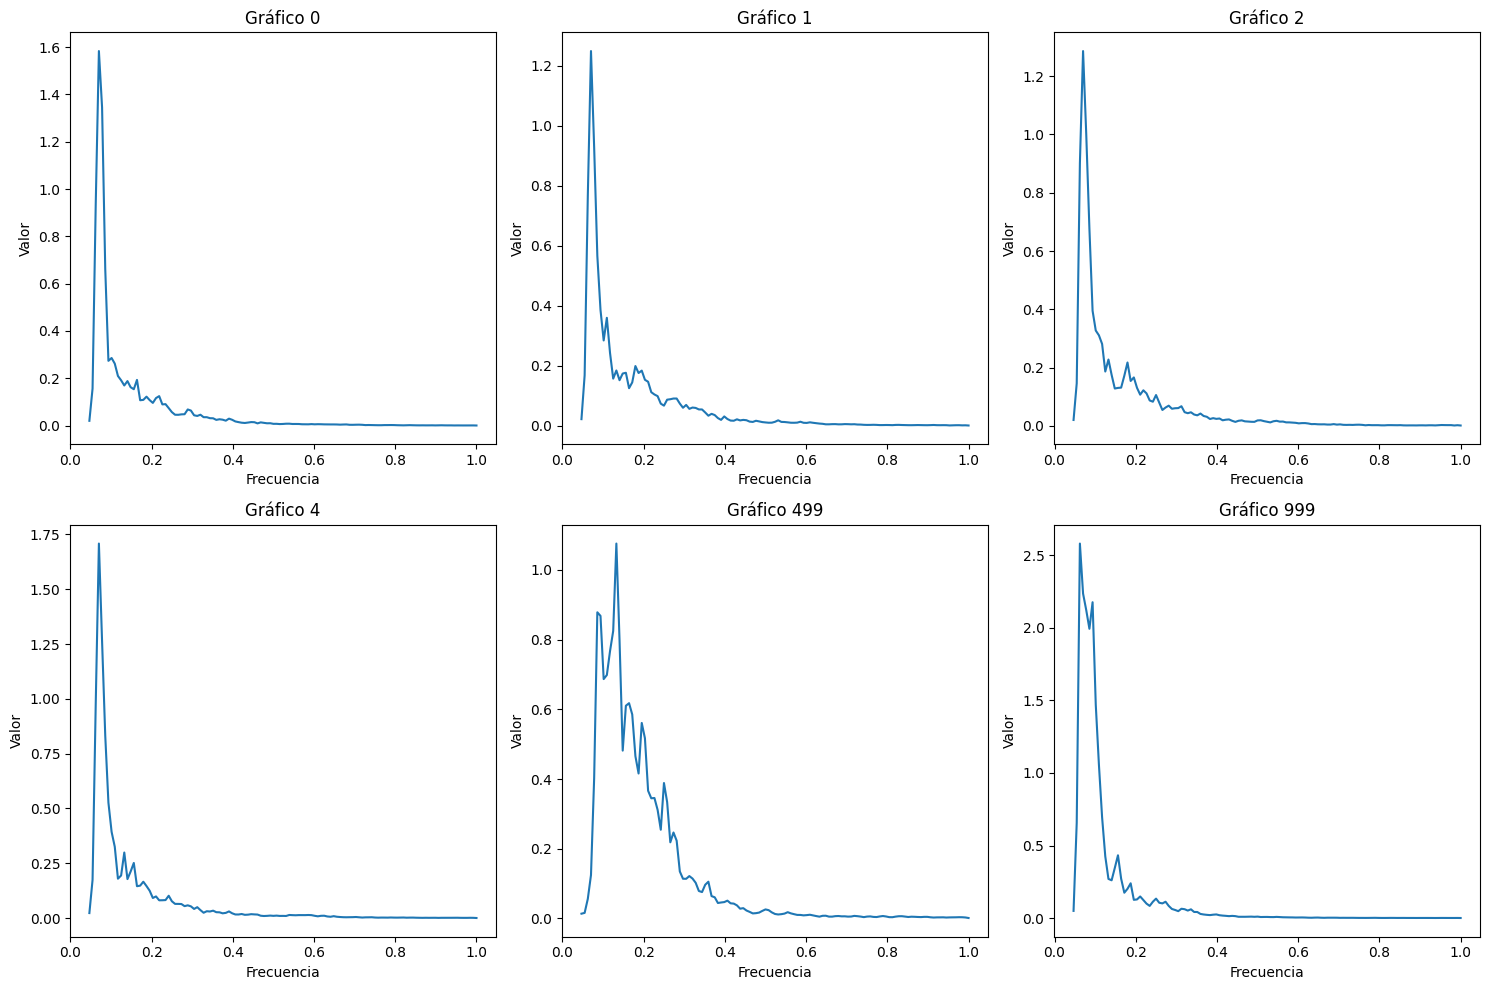

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Crear el grid de subplots

idx = [0, 1, 2, 4, 499, 999]  # Índices de los gráficos

# Asegúrate de que `axes` sea un arreglo aplanado para fácil acceso
axes = axes.flatten()

for k, i in enumerate(idx):
    # Simular los datos a graficar (ajusta esto según tu estructura de datos)
    em = data[i, :, 0]  # Aquí asumo que `data` tiene 3 dimensiones (filas, columnas, capa)

    # Seleccionar el subplot correspondiente
    ax = axes[k]
    ax.plot(freq, em)

    # Añadir título y etiquetas a cada gráfico
    ax.set_title(f'Gráfico {i}')
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Valor')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el grid de gráficos
plt.show()


---

### Creación del espectro con Welch

In [14]:
ocean_beach = pd.read_csv('../data/ocean/Australia/Torbay01.wst', sep='\s+', header=None)
fs = 2.0

<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:1: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_3373003/571860800.py:1: SyntaxWarning:

invalid escape sequence '\s'



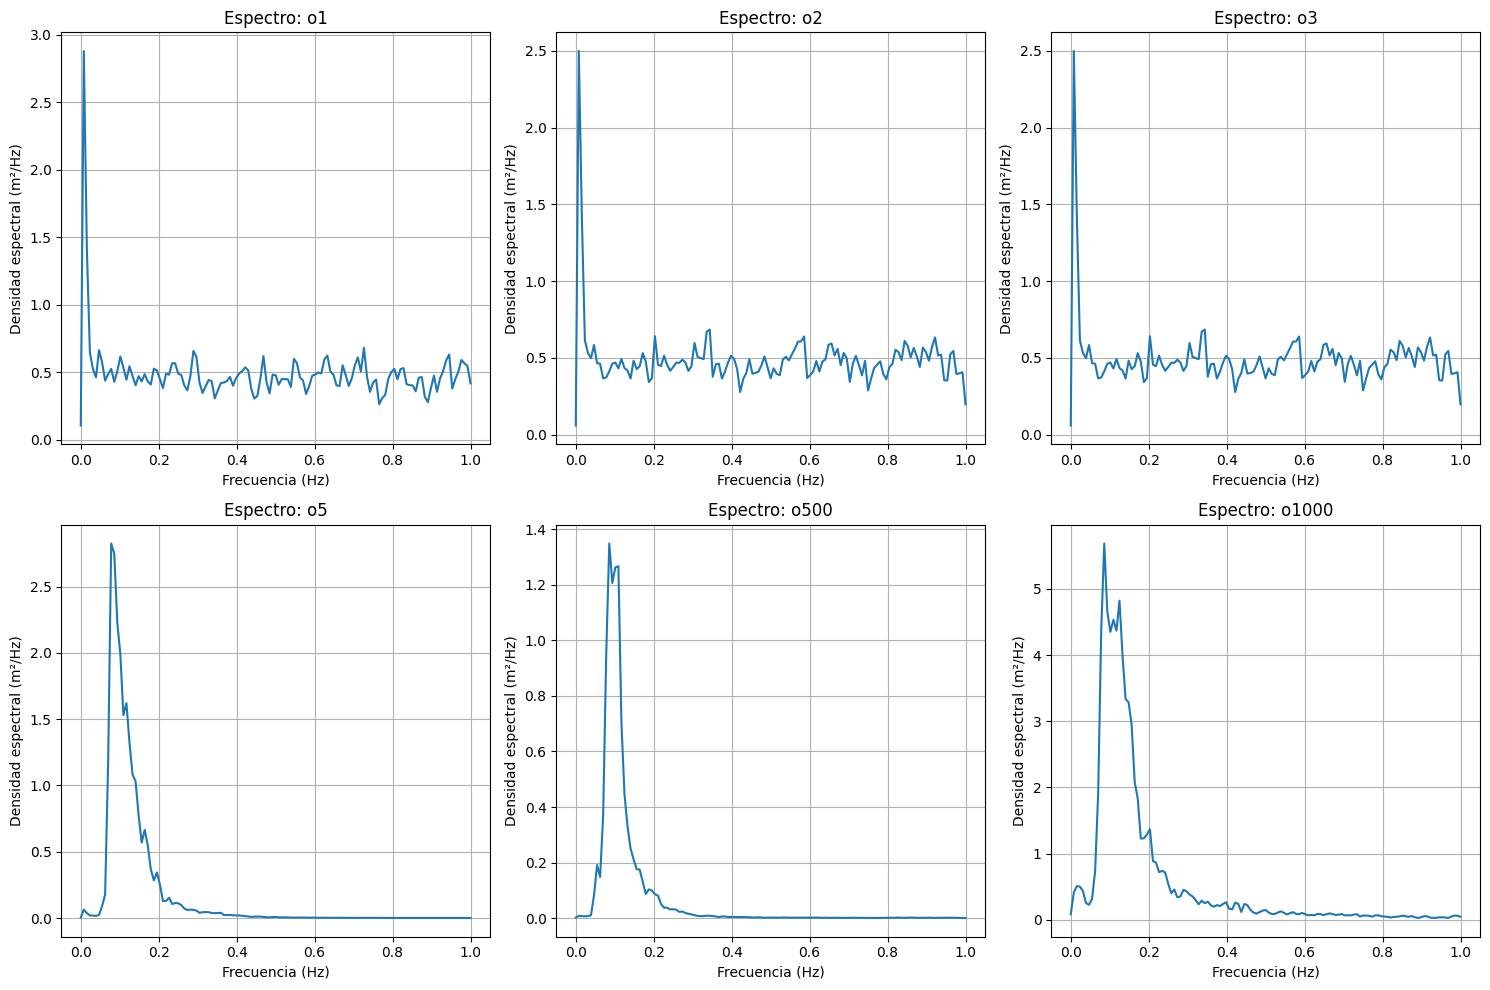

In [15]:
o1 = ocean_beach[ocean_beach[0] == 1]
o2 = ocean_beach[ocean_beach[0] == 2]
o3 = ocean_beach[ocean_beach[0] == 3]
o5 = ocean_beach[ocean_beach[0] == 5]
o50 = ocean_beach[ocean_beach[0] == 500]
o100 = ocean_beach[ocean_beach[0] == 1000]

datasets = [o1, o2, o3, o5, o50, o100]
labels = ["o1", "o2", "o3", "o5", "o500", "o1000"]

# Frecuencia de muestreo
fs = 2.0  # Ajustar a tu intervalo de muestreo real

# Crear el grid plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 filas, 3 columnas
axes = axes.flatten()  # Aplanar para iterar fácilmente

for i, (data, label, ax) in enumerate(zip(datasets, labels, axes)):
    # Cálculo del espectro con Welch
    frequencies, Pxx = welch(data[2], fs, nperseg=256)
    
    # Graficar en el subplot correspondiente
    ax.plot(frequencies, Pxx)
    ax.set_title(f"Espectro: {label}")
    ax.set_xlabel("Frecuencia (Hz)")
    ax.set_ylabel("Densidad espectral (m²/Hz)")
    ax.grid()

# Ajustar diseño
plt.tight_layout()
plt.show()

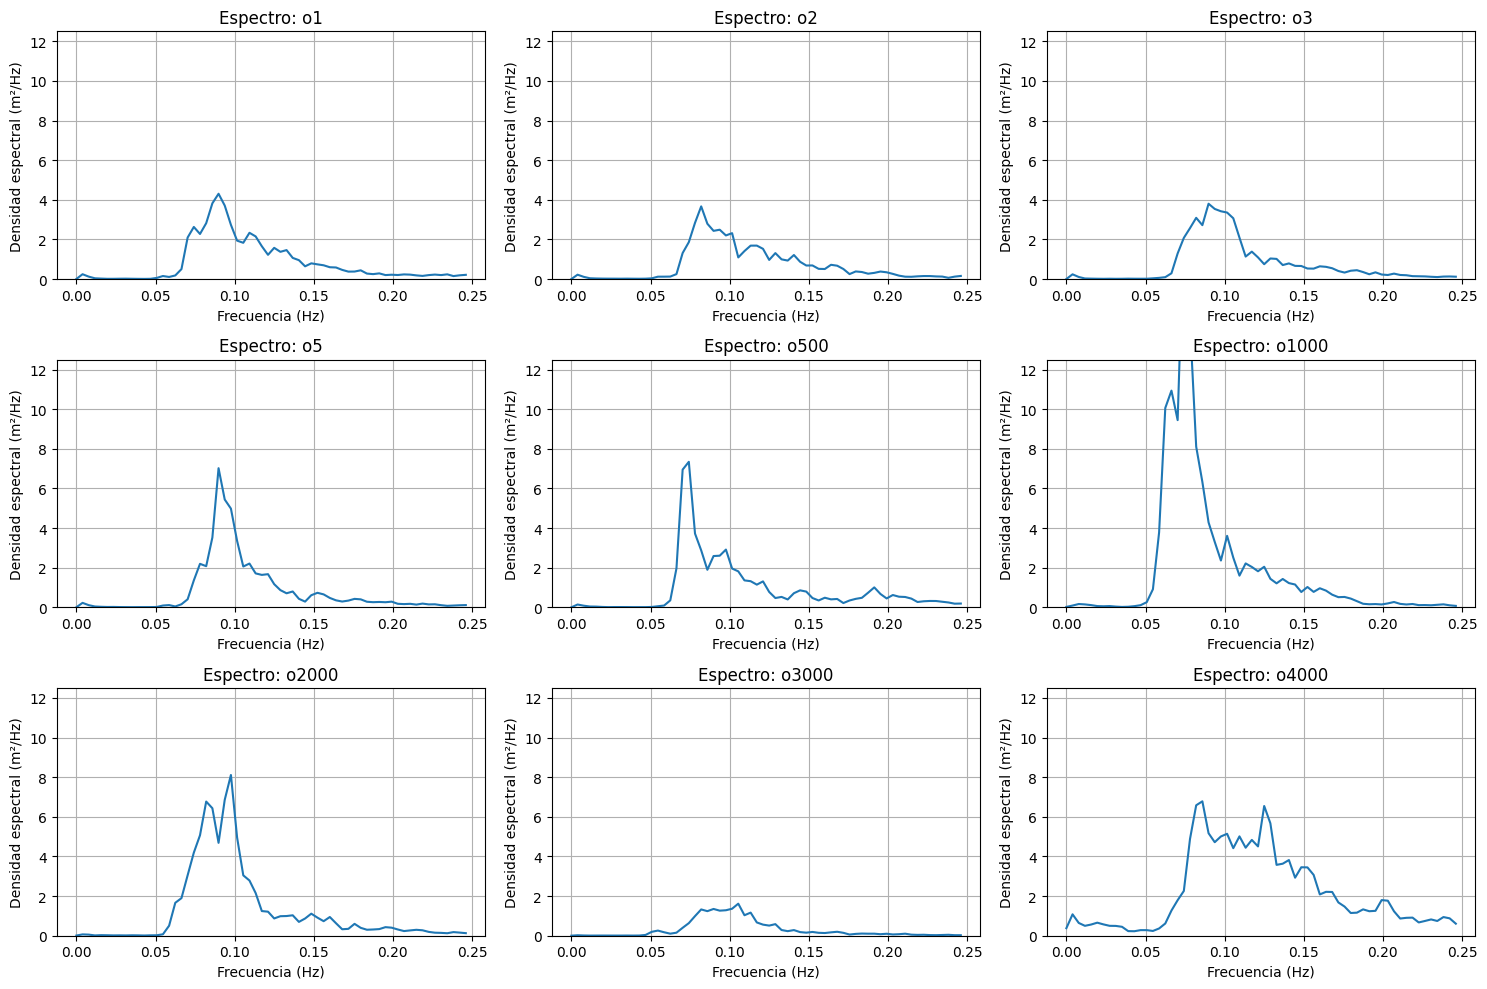

(257,)

In [16]:
o1 = ocean_beach[ocean_beach[0] == 4]
o2 = ocean_beach[ocean_beach[0] == 5]
o3 = ocean_beach[ocean_beach[0] == 6]
o5 = ocean_beach[ocean_beach[0] == 7]
o50 = ocean_beach[ocean_beach[0] == 50]
o100 = ocean_beach[ocean_beach[0] == 100]
o200 = ocean_beach[ocean_beach[0] == 200]
o300 = ocean_beach[ocean_beach[0] == 500]
o400 = ocean_beach[ocean_beach[0] == 1000]

datasets = [o1, o2, o3, o5, o50, o100, o200, o300, o400]
labels = ["o1", "o2", "o3", "o5", "o500", "o1000", "o2000", "o3000", "o4000"]

# Frecuencia de muestreo
fs = 2.0  # Ajustar a tu intervalo de muestreo real

# Crear el grid plot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 2 filas, 3 columnas
axes = axes.flatten()  # Aplanar para iterar fácilmente

for i, (data, label, ax) in enumerate(zip(datasets, labels, axes)):
    # Cálculo del espectro con Welch
    fs_ = 2.0
    nperseg = 256 * fs_
    frequencies, Pxx = welch(data[2], fs, nperseg=nperseg)
    
    # Graficar en el subplot correspondiente
    ax.plot(frequencies[:int(nperseg//8)], Pxx[:int(nperseg//8)])
    ax.set_title(f"Espectro: {label}")
    ax.set_xlabel("Frecuencia (Hz)")
    ax.set_ylabel("Densidad espectral (m²/Hz)")
    ax.set_ylim(0,12.5)
    ax.grid()

# Ajustar diseño
plt.tight_layout()

plt.show()
frequencies.shape

In [17]:
bursts = ocean_beach[0].unique()

data = []

for burst in bursts:
    frequencies, Pxx = welch(ocean_beach[ocean_beach[0] == burst][2], fs, nperseg=256 * 2.0)
    menos4 = len(frequencies[frequencies < 0.04])
    
    data.append(Pxx[menos4:])


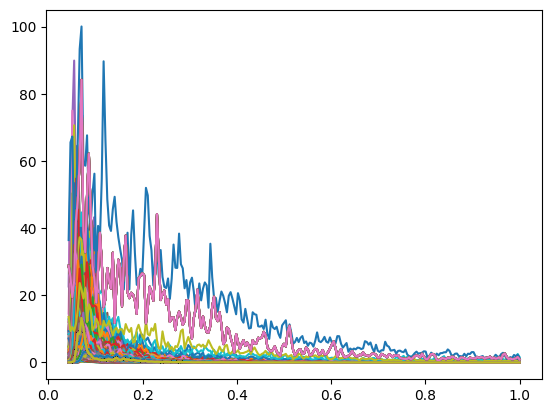

In [18]:
plt.plot(frequencies[frequencies > 0.04], np.array(data).T)
plt.show()

In [19]:
data = np.array(data[3:])
data = data[:, :, np.newaxis]

In [20]:
menos4 = len(frequencies[frequencies < 0.04])
freq = frequencies[menos4:]

In [21]:
np.save('Torbay01.npy', data)
np.save('freq.npy', freq)

---

## Clustering

In [22]:
data = np.load('../data/ocean/Australia/Torbay01.npy')
freq = np.load('../data/ocean/Australia/freq.npy')

In [23]:
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of hs: (1616, 1)
How much spectra falls in the range 0.5-3.0 Hs: 1600


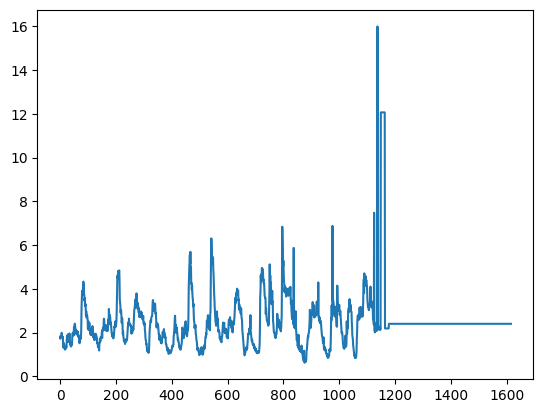

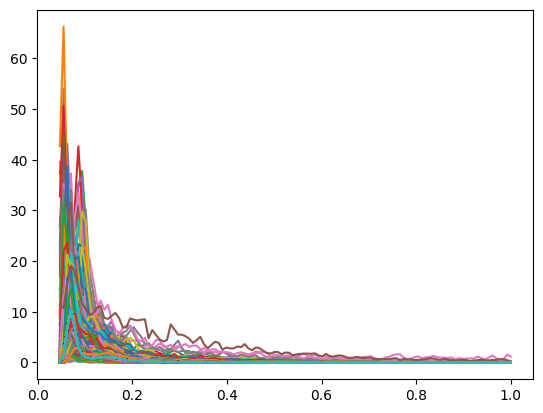

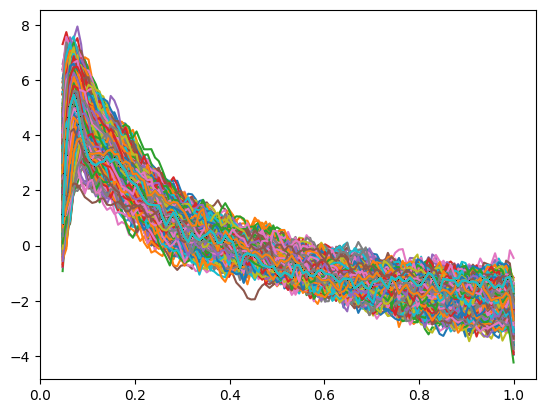

In [24]:
#Here we are going to compute the heights and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data[:,:,0] @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.5) & (hs < 8.0))[0]
#chosen_indexes = np.arange(0, num_samples)
print("How much spectra falls in the range 0.5-3.0 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()

In [25]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(1600, 123, 1)


In [26]:
chosen_indexes = np.where((freq > 0) & (freq <= 0.5))[0]

#Select indexes
freq = freq[chosen_indexes]
print("Shape of the data: ")
print(freq.shape)

Shape of the data: 
(59,)


### Ocean beach

In [27]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.05
# 13 clusters
std_dif = std_dif * 0.001
# std_dif = std_dif * 0.075
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.026548811562317472
Gamma estimated: 0.026548811562317472
Final sigma: 0.0013274405781158738
Final gamma: 2.654881156231747e-05
Final sigma bound: (1.3274405781158736e-10, 0.00013274405781158737)
Final gamma bound: (2.6548811562317472e-14, 2.6548811562317474e-06)


In [28]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 1.0
ini_lengthscale = 1e-2
bound_lengthscale = (1e-7, 5e-1)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
n_freq = 30
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[:n_freq]).T
x_train = np.atleast_2d(freq[:n_freq]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

(30, 1)


In [29]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=10, free_deg_MNIV=5)

#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data[:num_samples,0:n_freq,[0]])

------ HDP Hyperparameters ------
gamma: 0.8
transAlpha: 0.8
startAlpha: 0.8
kappa: 0.0
---------------------------------
Group responsability estimated: [1600]
---Kernel estimated---
0.869**2 * RBF(length_scale=0.0101) + WhiteKernel(noise_level=0.000119)
Step 1/10- Trying to divide: 0 with beat 751
---Kernel estimated---
2.4**2 * RBF(length_scale=0.00709) + WhiteKernel(noise_level=0.000124)
Sum resp_temp: [1587   13]
Q_em: -108881.26, Q_lat: -19498205.04, Elbo_linear: -40.21, Elbo_LDS: -5226.54
>>> Q_all_loop -------
Sum resp_temp: [1587   13]
Q_em: -108881.26, Q_lat: -19498205.04, Elbo_linear: -40.21, Elbo_LDS: -5226.54
Sum resp_temp: [1599    1]
Q_em: -69390.81, Q_lat: -20078607.46, Elbo_linear: -8.22, Elbo_LDS: -5200.98
Sum resp_temp: [1587   13]
Q_em: -108881.26, Q_lat: -19498205.04, Elbo_linear: -40.21, Elbo_LDS: -5226.54
ELBO_reduction: 0.0
>>> Prev -------
Sum resp_temp: [1600]
Q_em: -69439.52, Q_lat: -20118741.24, Elbo_linear: 0.52, Elbo_LDS: -5189.23
>>> Post -------
Sum resp

In [30]:
from matplotlib.colors import to_hex
color = {0: 'k', 1: 'b', 2: 'r', 3: 'g', 4: 'c', 5: 'purple', 6: 'darkgreen', 7: 'maroon',
         8: 'orange', 9: 'lightgreen', 10: 'magenta', 11: 'lightblue', 12: 'darkblue', 13: 'red',
         14: 'red', 15: 'goldenrod', 16: 'red'}
labels_trans = {'N': 1, 'V': 2, 'R': 3, '!': 4, 'F': 5, 'L': 6, 'A': 7, '/': 8, 'Q': 9, 'f': 10, 'E': 11,
                'J': 12, 'j': 13, 'e': 14, 'a': 15, 'S': 16}
def plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0, title=None, save=None, lead=0, step=0.1, plot_latent=False, ticks=False, yscale=False):
    num_models = len(selected_gpmodels)
    num_cols = int(np.ceil(np.sqrt(num_models)))
    num_rows = int(np.ceil(num_models / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
    axes = axes.flatten()

    def col_fun(lab):
        if type(labels[0]) is np.int32:
            return to_hex(color.get(lab, 'b'))
        else:
            return to_hex(color.get(labels_trans.get(lab, 0), 'b'))

    for i, m in enumerate(selected_gpmodels):
        ax = axes[i]
        gp = sw_gp.gpmodels[lead][m]

        # Plot training data
        for j_, d in enumerate(gp.y_train):
            j = gp.indexes[j_]
            x_t = gp.x_train[j_].T[0]
            d = sw_gp.y_train[j,:,[lead]]
            if isinstance(d, torch.Tensor):
                d = d.detach().cpu()
                x_t = x_t.cpu()
            ax.plot(x_t, d.T[0], alpha=max(0.07, 0.5 / (np.log(len(gp.y_train) - j_ + 1) + 1)),
                    color=col_fun(labels[j + N_0]), linewidth=1.2)

        # Mean and variance
        x_b = gp.x_basis.T[0]
        if (x_b[1] - x_b[0]) == step:
            x_ = torch.clone(x_b)
        else:
            x_ = torch.arange(min(x_b), max(x_b), step, dtype=torch.float64).cpu()

        mean_, Sig_ = gp.observe_last(torch.atleast_2d(x_).T)
        #mean_l, Sig_l = gp.step_forward_last(torch.atleast_2d(x_).T)

        noise_ob = np.sqrt(np.diag(Sig_.cpu()))
        mean = mean_.cpu().T[0]
        neg_lim = mean - 1.9 * noise_ob
        #neg_lim[neg_lim < 0.0] = 0.0
        ax.plot(x_, mean, color='black', linewidth=2, label=f'Emission GP mean [{m + 1}]')
        ax.fill_between(x_, neg_lim, mean + 1.9 * noise_ob, color=col_fun(main_model[i]), alpha=0.3)

        # Latent mean
        mean_latent = gp.f_star_sm[-1].cpu().T[0]
        noise_lat = 1.9 * np.sqrt(np.diag(gp.Gamma[-1].cpu()))
        neg_lim = mean_latent - noise_lat
        #neg_lim[neg_lim < 0.0] = 0.0
        # ax.plot(x_b.cpu(), mean_latent, color='grey', linewidth=1.5, label=f'Latent GP Mean [{m + 1}]')
        ax.fill_between(x_b.cpu(), neg_lim, mean_latent+noise_lat, color=col_fun(main_model[i]), alpha=0.22)

        #Experimental mean
        mean = np.mean(np.array(gp.y_train), axis=0)
        ax.plot(x_b.cpu(), mean, color='black', linewidth=2, label=f'Experimental mean [{m + 1}]', linestyle='--')

        if title is None:
            ax.set_title(f"ECG CLUSTER {m + 1} ({main_model[m]})")
        else:
            ax.set_title(title)
        #ax.grid(True)
    if yscale:
        for ax in fig.get_axes():
            ax.set_ylim(np.min(sw_gp.y_train.numpy())-0.5, np.max(sw_gp.y_train.numpy()) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))
    if not ticks:
        for ax in fig.get_axes():
        #     ax.label_outer()
        #     ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
        #     ax.set_yticks([])
    # Hide unused subplots
    for j in range(len(axes)):
        if j >= num_models:
            axes[j].axis('off')

    fig.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

#### Ocean Beach 13

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


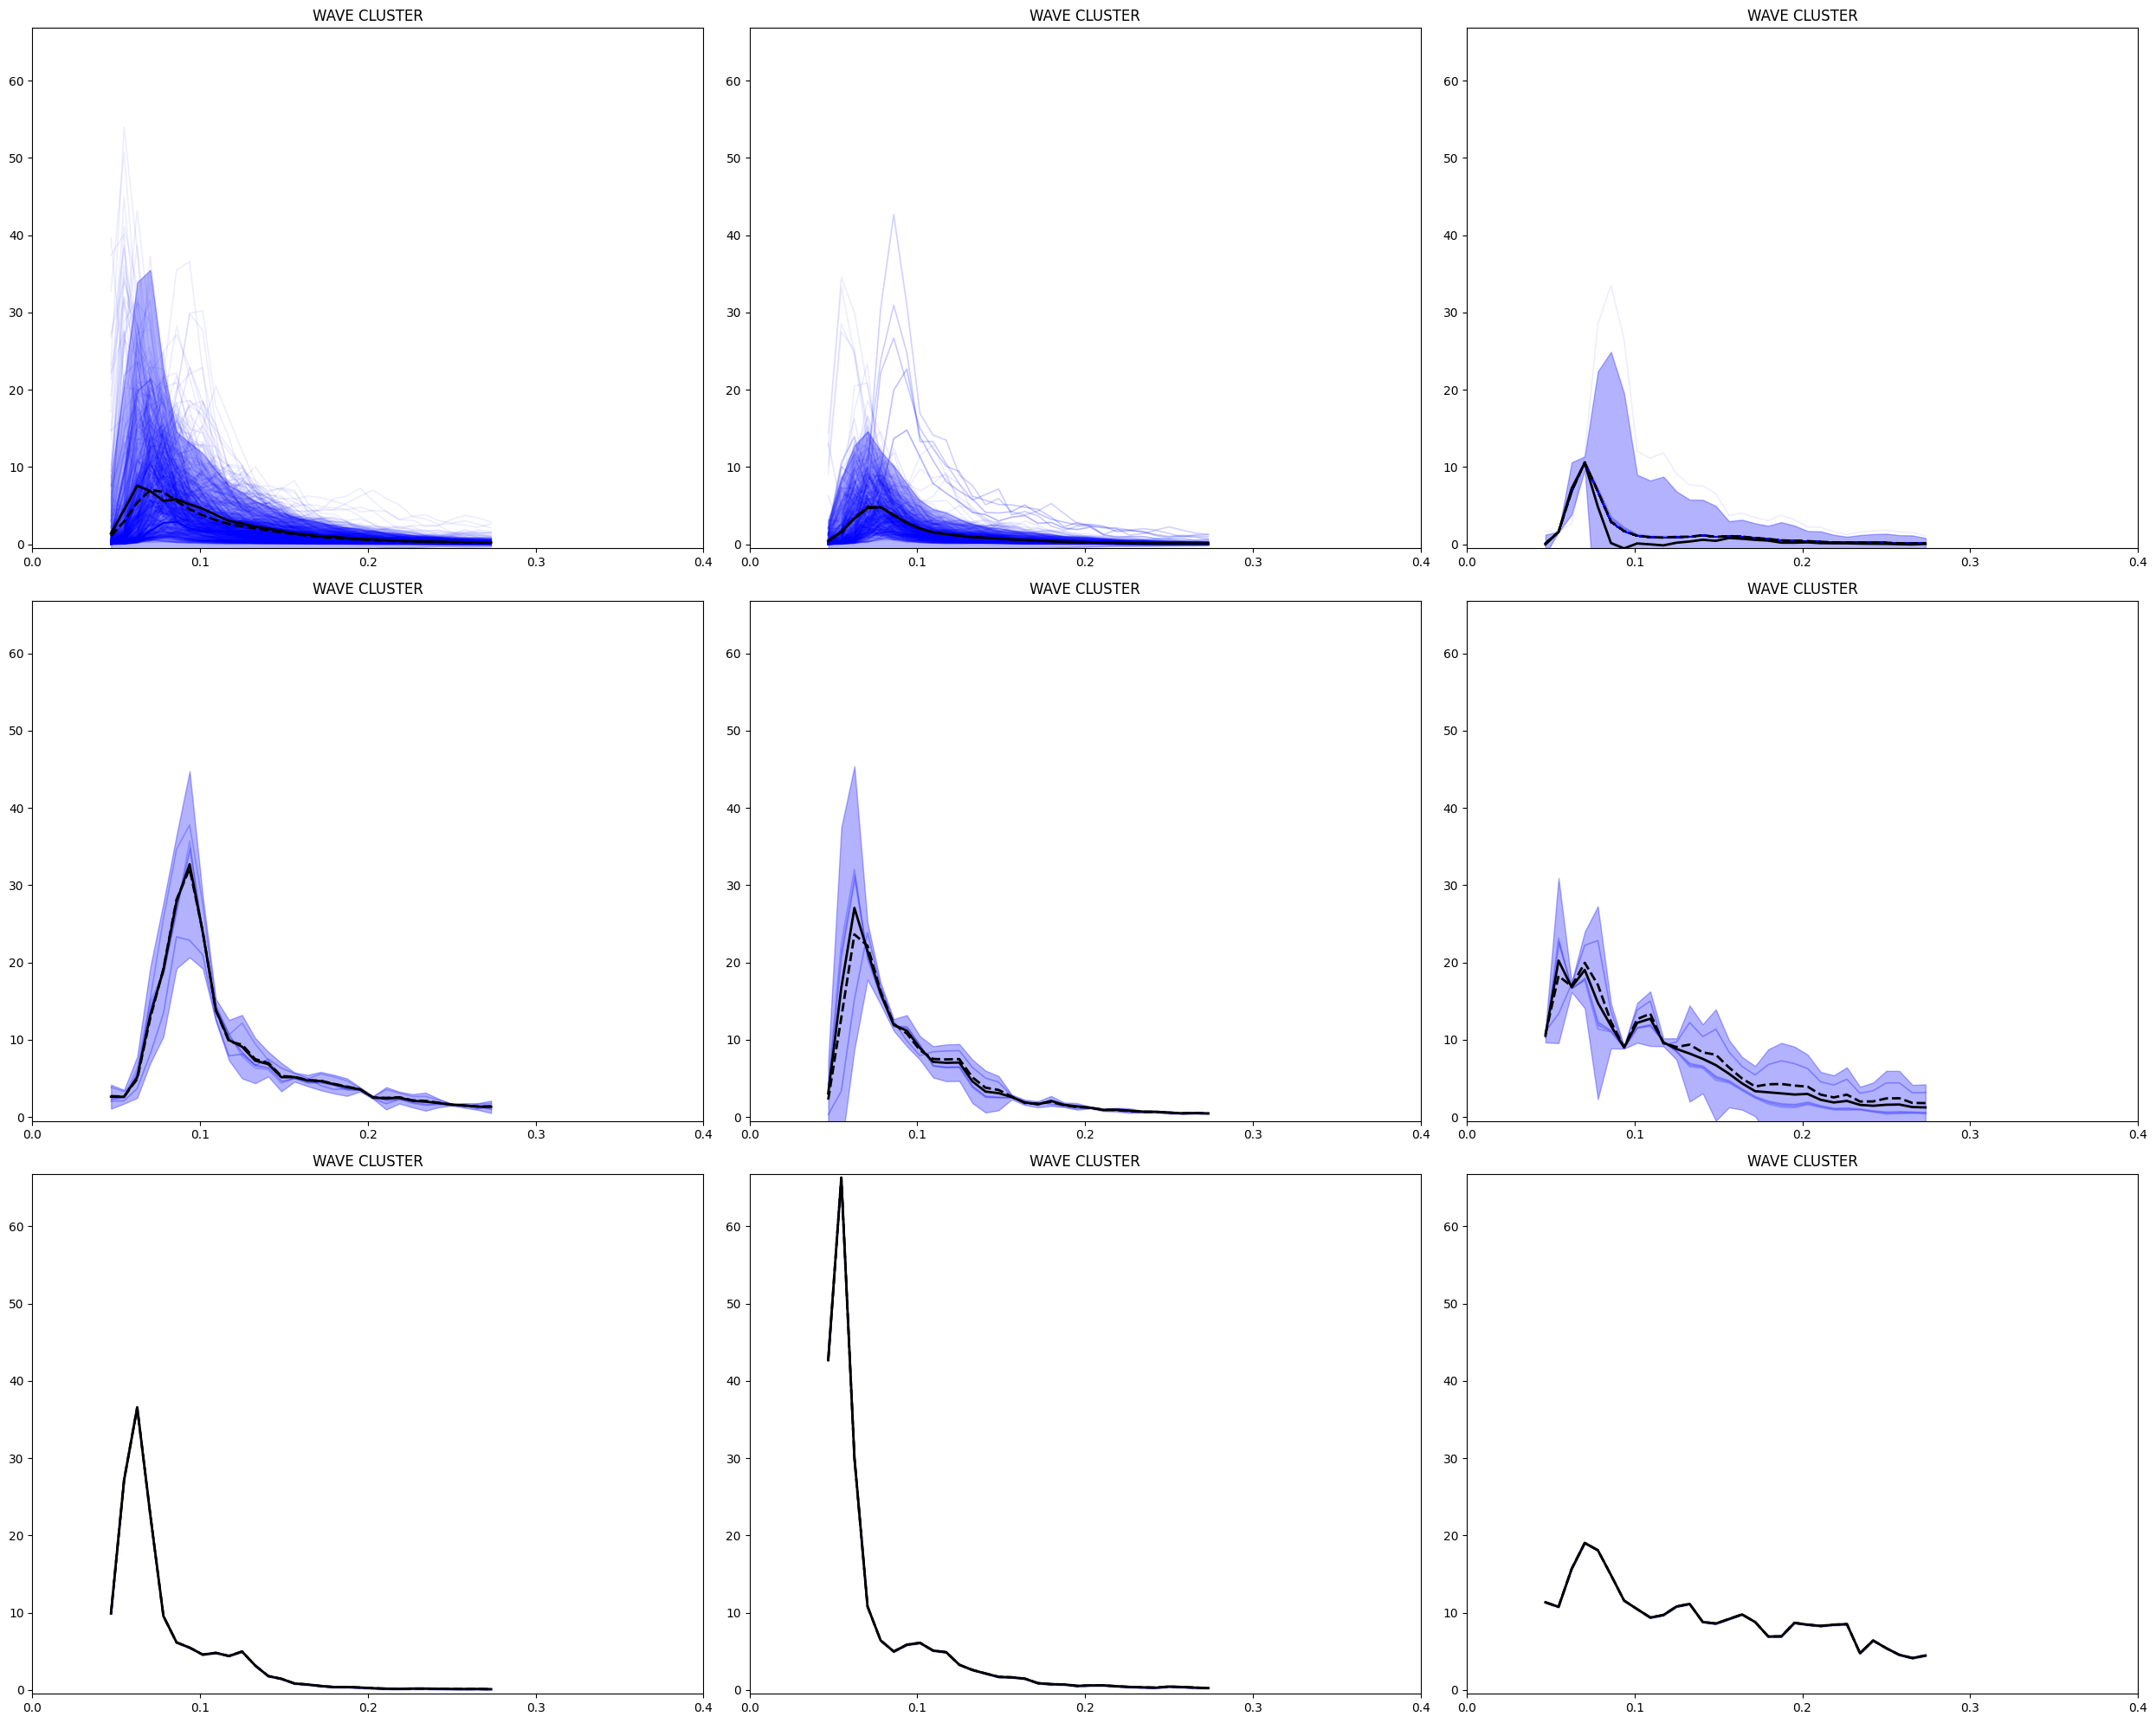

In [31]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Ocean Beach 14

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


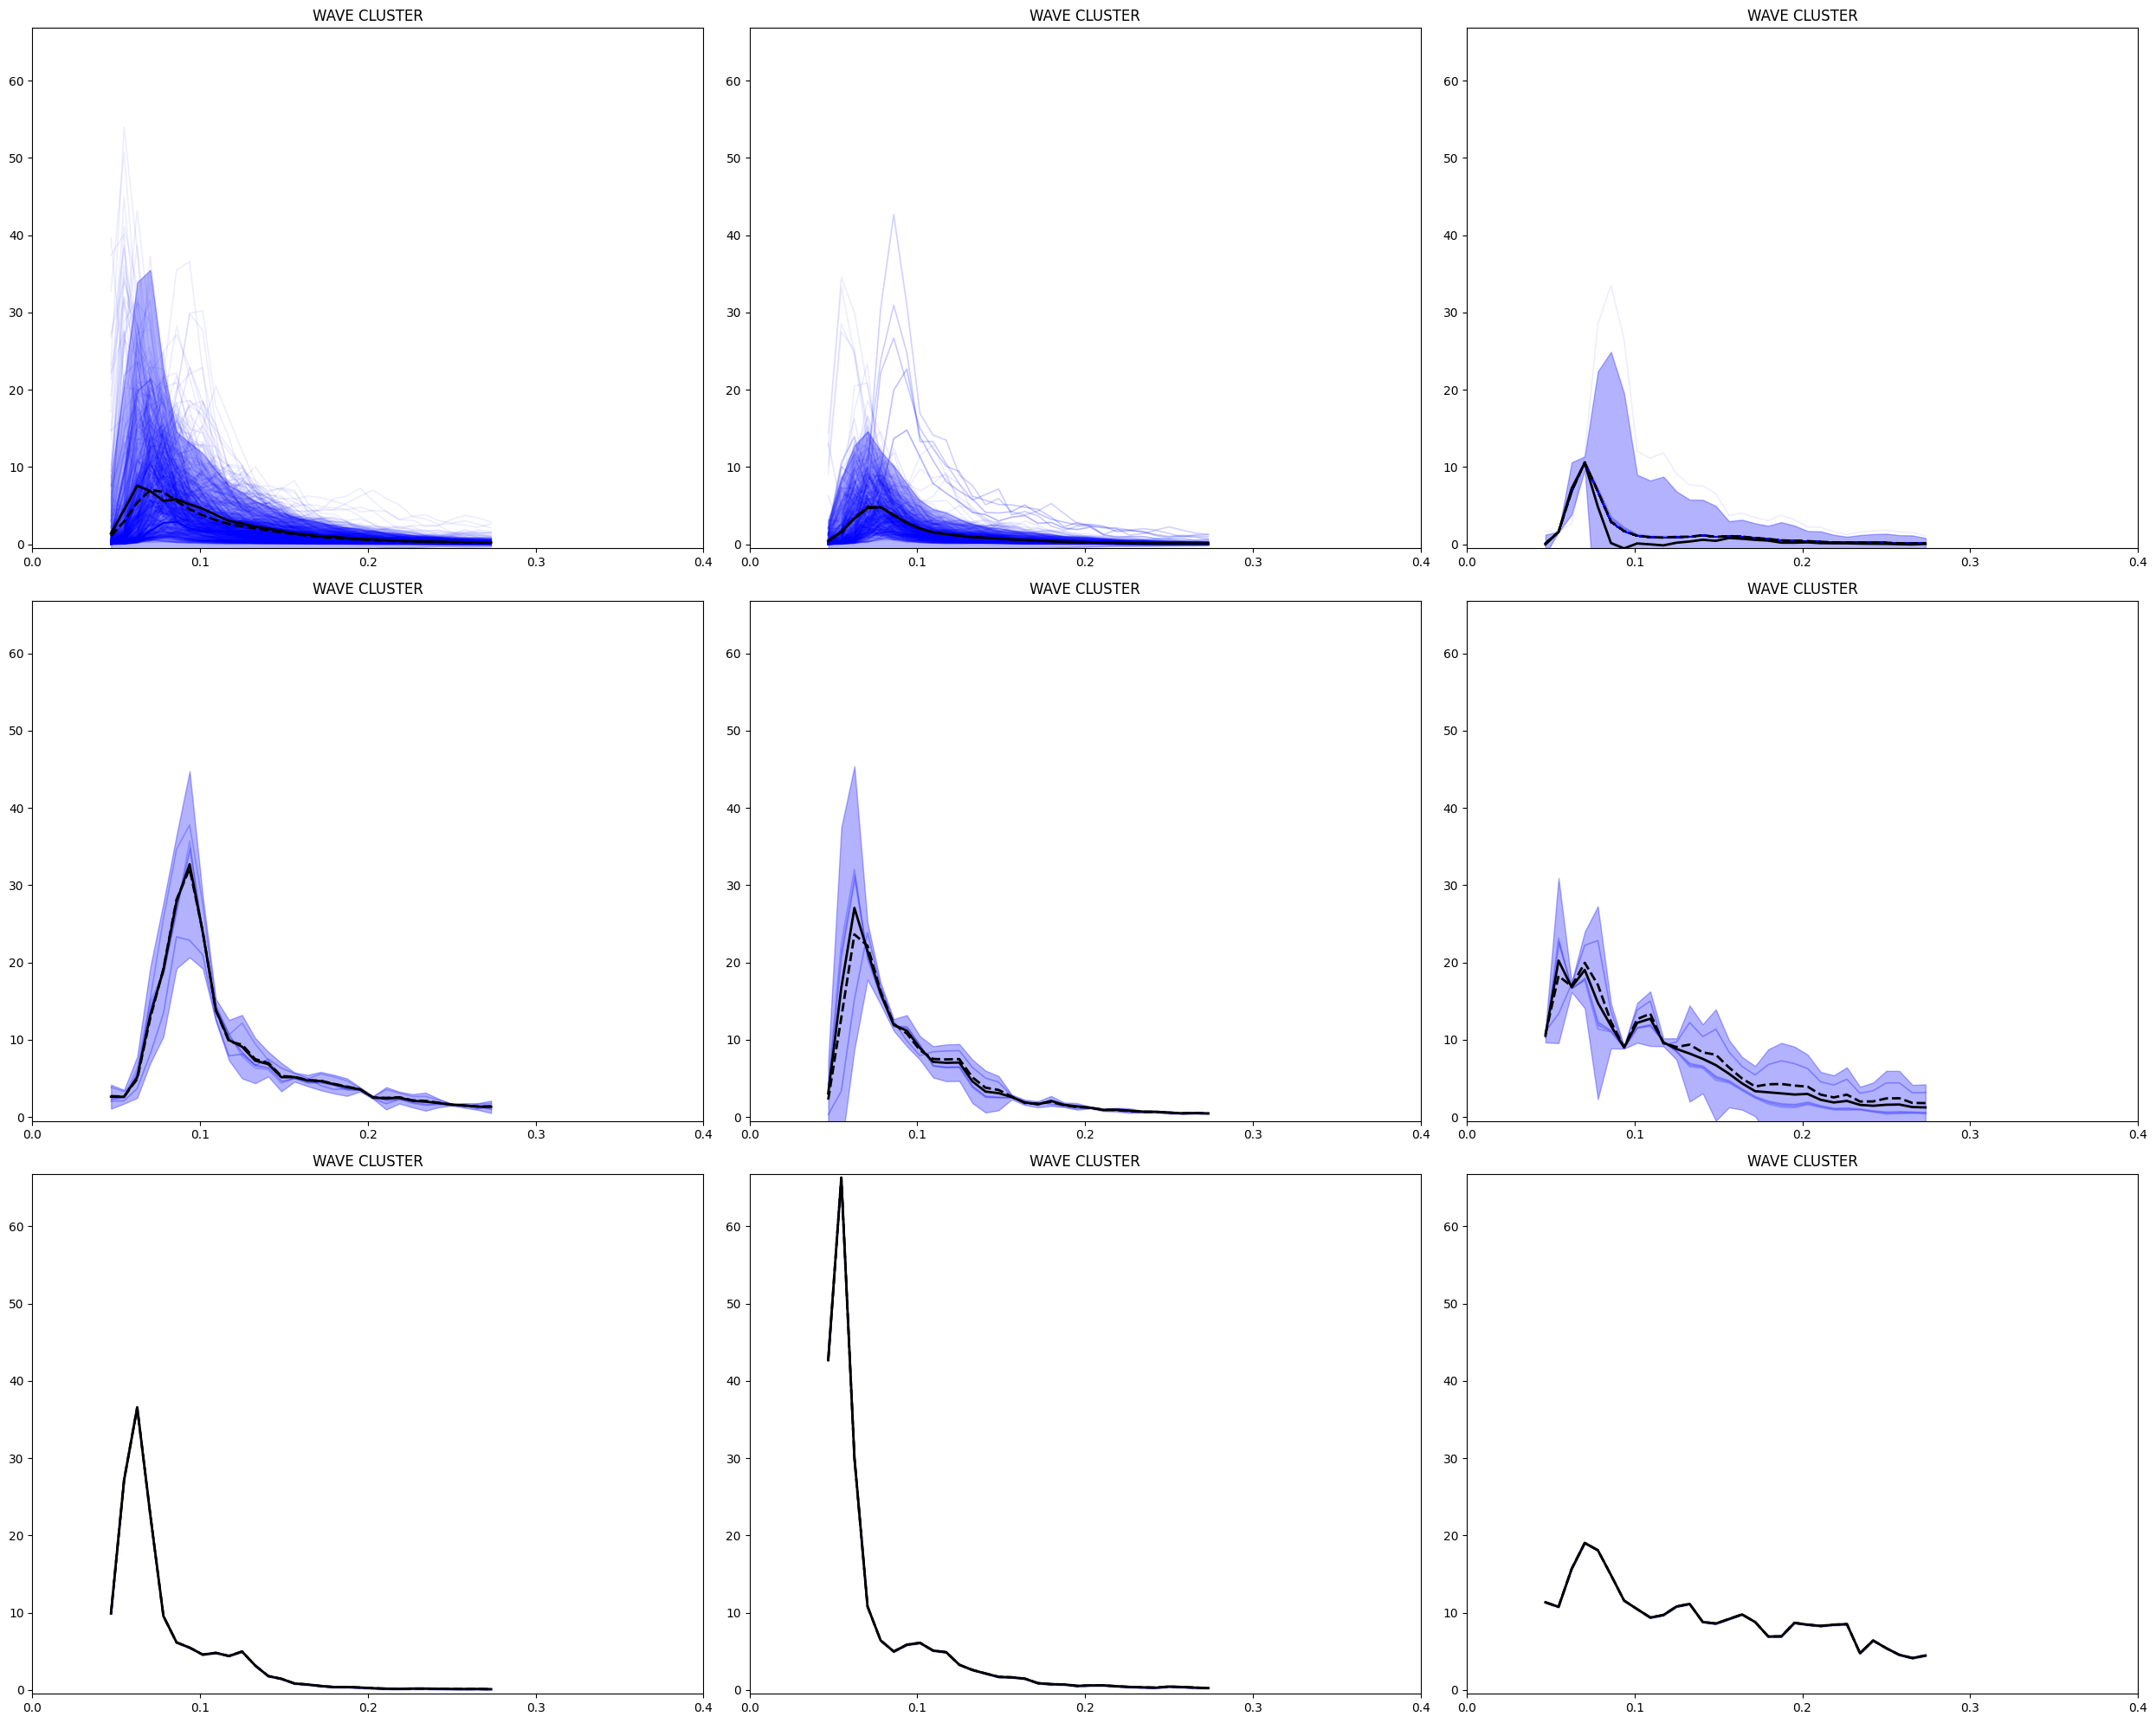

In [32]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Ocean Beach 16 Log

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


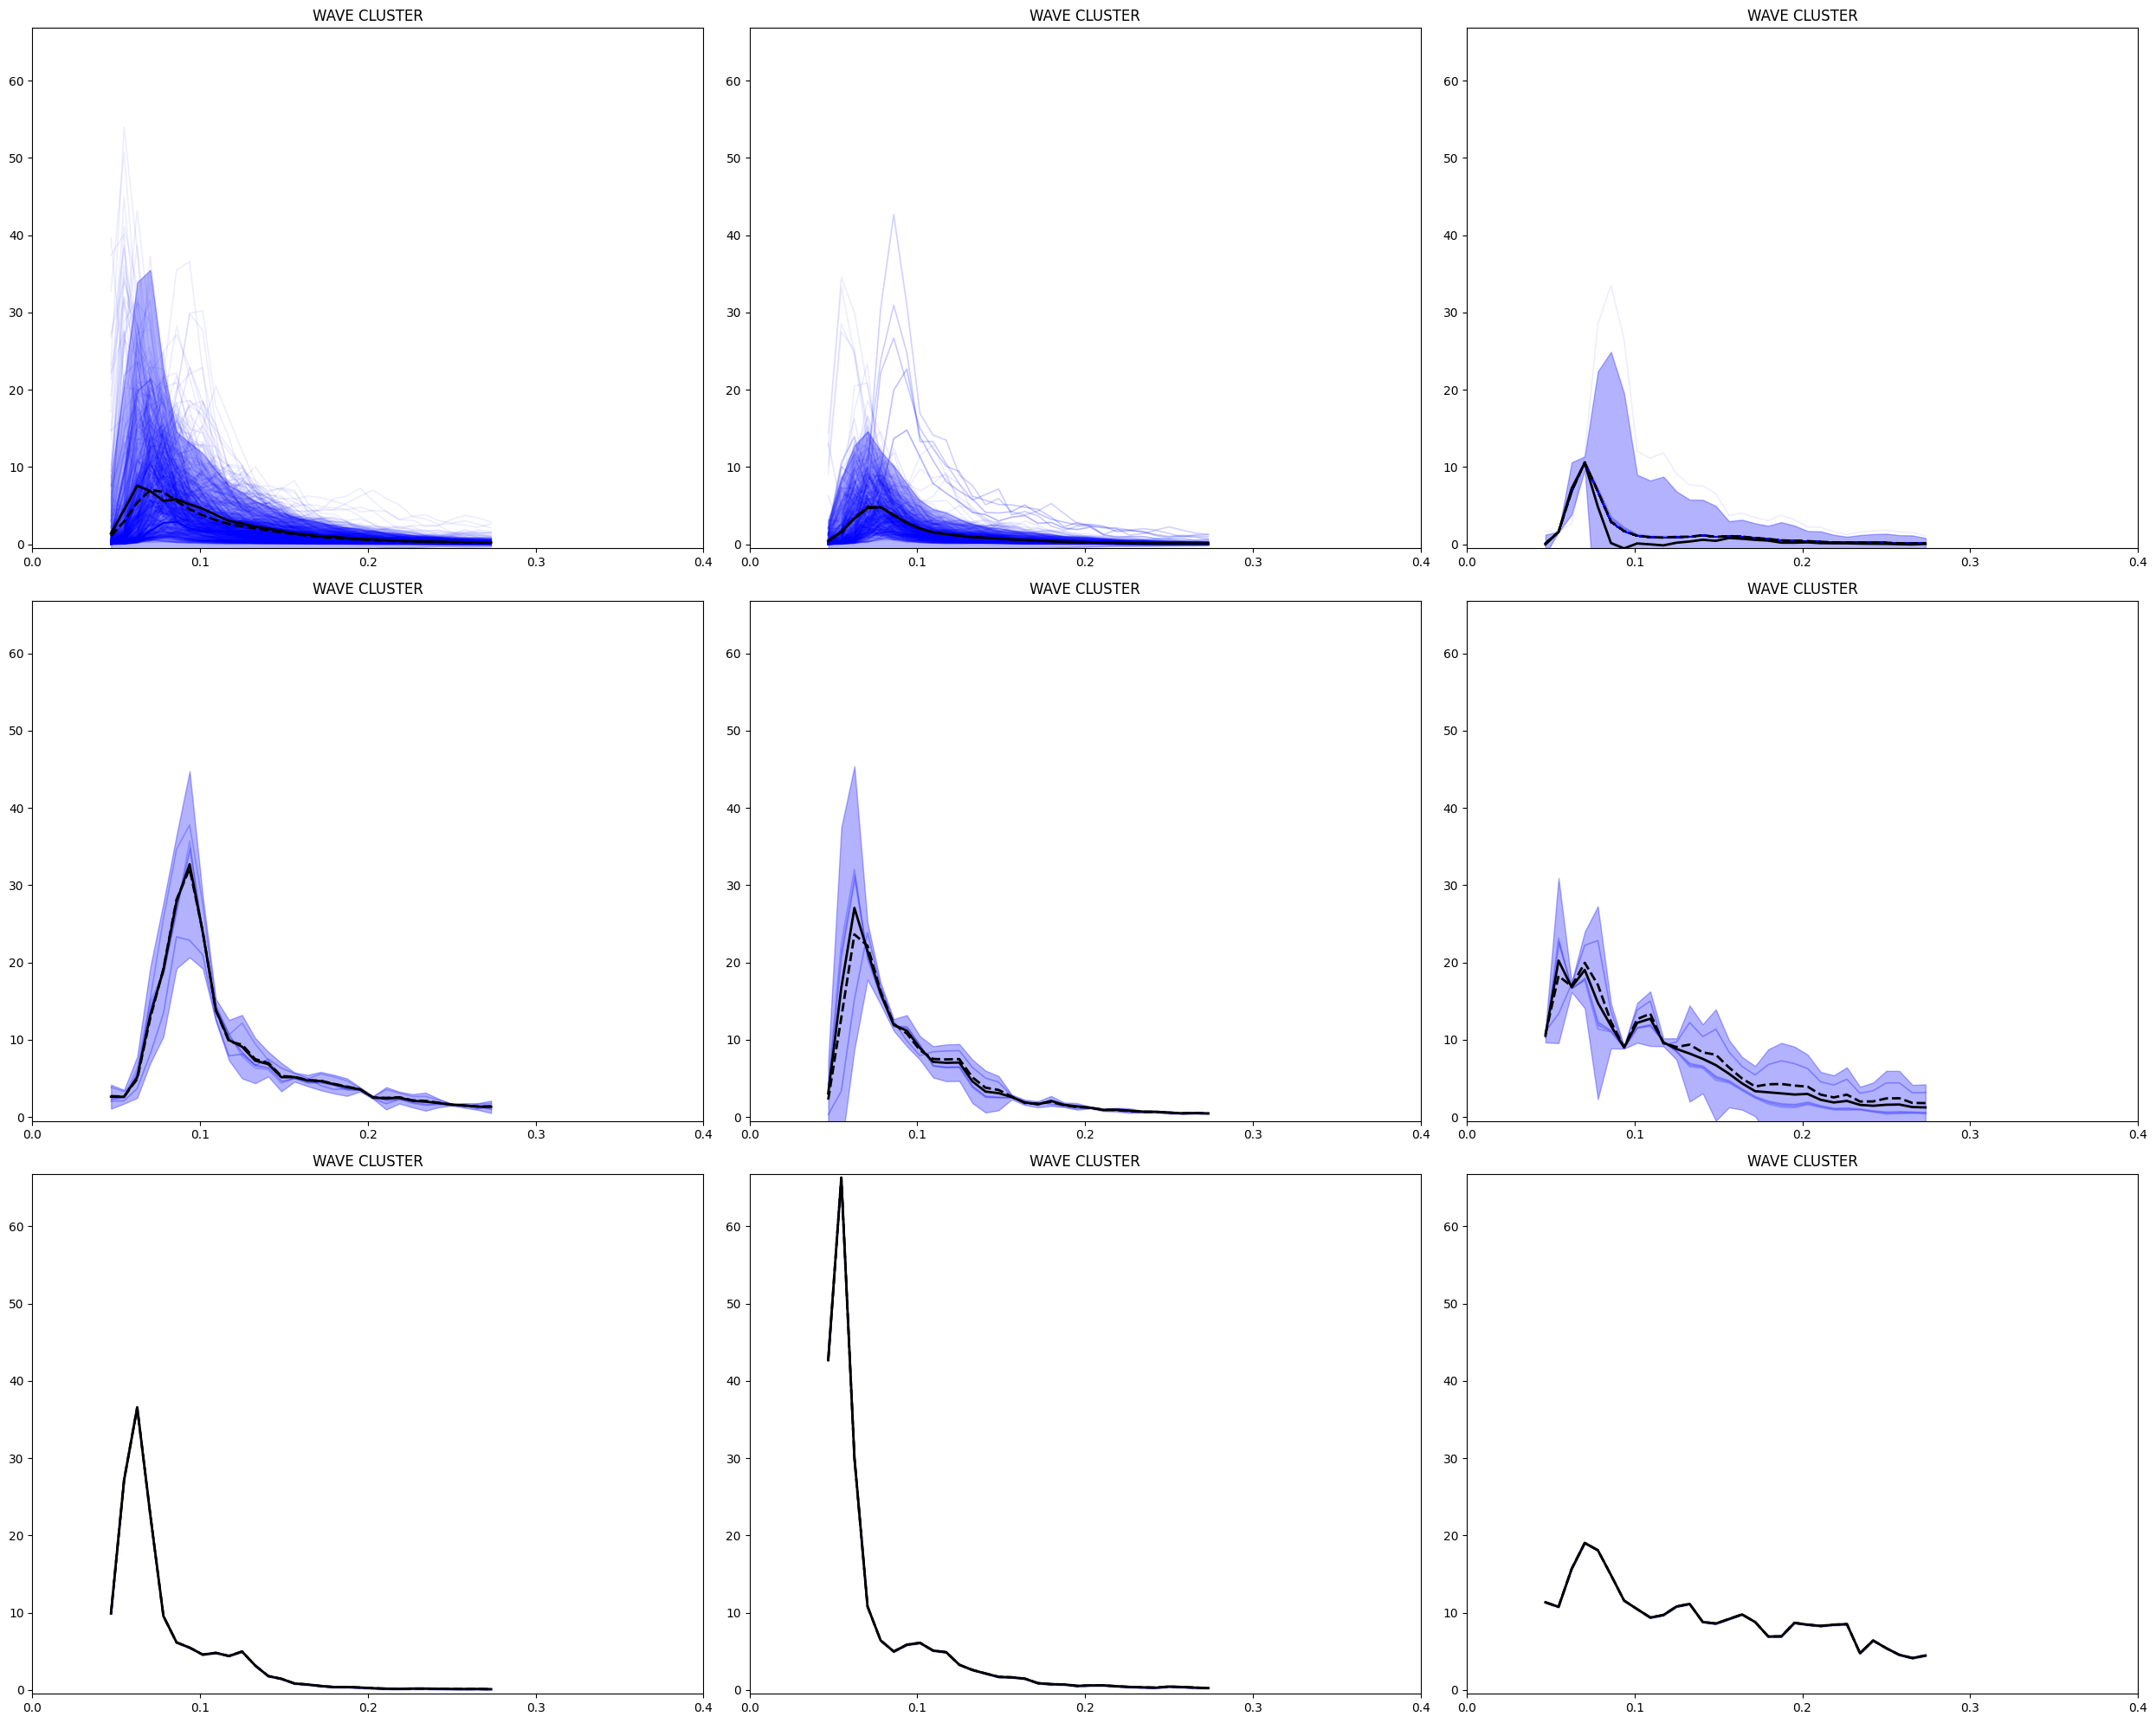

In [33]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

In [34]:
from matplotlib.colors import to_hex
color = {0: 'k', 1: 'b', 2: 'r', 3: 'g', 4: 'c', 5: 'purple', 6: 'darkgreen', 7: 'maroon',
         8: 'orange', 9: 'lightgreen', 10: 'magenta', 11: 'lightblue', 12: 'darkblue', 13: 'red',
         14: 'red', 15: 'goldenrod', 16: 'red'}
labels_trans = {'N': 1, 'V': 2, 'R': 3, '!': 4, 'F': 5, 'L': 6, 'A': 7, '/': 8, 'Q': 9, 'f': 10, 'E': 11,
                'J': 12, 'j': 13, 'e': 14, 'a': 15, 'S': 16}
def plot_models_plotly_log(sw_gp, selected_gpmodels, main_model, labels, N_0, title=None, save=None, lead=0, step=0.1, plot_latent=False, ticks=False, yscale=False):
    num_models = len(selected_gpmodels)
    num_cols = int(np.ceil(np.sqrt(num_models)))
    num_rows = int(np.ceil(num_models / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
    axes = axes.flatten()

    def col_fun(lab):
        if type(labels[0]) is np.int32:
            return to_hex(color.get(lab, 'b'))
        else:
            return to_hex(color.get(labels_trans.get(lab, 0), 'b'))

    for i, m in enumerate(selected_gpmodels):
        ax = axes[i]
        gp = sw_gp.gpmodels[lead][m]

        # Plot training data
        for j_, d in enumerate(gp.y_train):
            j = gp.indexes[j_]
            x_t = gp.x_train[j_].T[0]
            d = np.exp(sw_gp.y_train[j,:,[lead]] - 1e-6)
            if isinstance(d, torch.Tensor):
                d = d.detach().cpu()
                x_t = x_t.cpu() 
            ax.plot(x_t, d.T[0], alpha=max(0.07, 0.5 / (np.log(len(gp.y_train) - j_ + 1) + 1)),
                    color=col_fun(labels[j + N_0]), linewidth=1.2)

        # Mean and variance
        x_b = gp.x_basis.T[0]
        if (x_b[1] - x_b[0]) == step:
            x_ = torch.clone(x_b)
        else:
            x_ = torch.arange(min(x_b), max(x_b), step, dtype=torch.float64).cpu()

        mean_, Sig_ = gp.observe_last(torch.atleast_2d(x_).T)
        #mean_l, Sig_l = gp.step_forward_last(torch.atleast_2d(x_).T)

        noise_ob = np.sqrt(np.diag(Sig_.cpu()))
        mean = np.exp(mean_.cpu().T[0] - 1e-6)
        neg_lim = mean - 1.9 * noise_ob
        neg_lim[neg_lim < 0.0] = 0.0
        ax.plot(x_, mean, color='black', linewidth=2, label=f'Emission GP mean [{m + 1}]')
        ax.fill_between(x_, neg_lim - 1e-6, mean + 1.9 * noise_ob, color=col_fun(main_model[i]), alpha=0.3)

        # Latent mean
        mean_latent = np.exp(gp.f_star_sm[-1].cpu().T[0])
        noise_lat = 1.9 * np.sqrt(np.diag(gp.Gamma[-1].cpu()))
        neg_lim = mean_latent - noise_lat
        neg_lim[neg_lim < 0.0] = 0.0
        # ax.plot(x_b.cpu(), mean_latent, color='grey', linewidth=1.5, label=f'Latent GP Mean [{m + 1}]')
        ax.fill_between(x_b.cpu(), neg_lim - 1e-6, mean_latent+noise_lat, color=col_fun(main_model[i]), alpha=0.22)

        #Experimental mean
        mean = np.exp(np.mean(np.array(gp.y_train), axis=0))
        ax.plot(x_b.cpu(), mean - 1e-6, color='black', linewidth=2, label=f'Experimental mean [{m + 1}]', linestyle='--')

        if title is None:
            ax.set_title(f"ECG CLUSTER {m + 1} ({main_model[m]})")
        else:
            ax.set_title(title)
        #ax.grid(True)
    if yscale:
        for ax in fig.get_axes():
            ax.set_ylim(np.min(np.exp(sw_gp.y_train.numpy() - 1e-6))-0.5, np.max(np.exp(sw_gp.y_train.numpy() - 1e-6)) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))
    if not ticks:
        for ax in fig.get_axes():
        #     ax.label_outer()
        #     ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
        #     ax.set_yticks([])
    # Hide unused subplots
    for j in range(len(axes)):
        if j >= num_models:
            axes[j].axis('off')

    fig.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


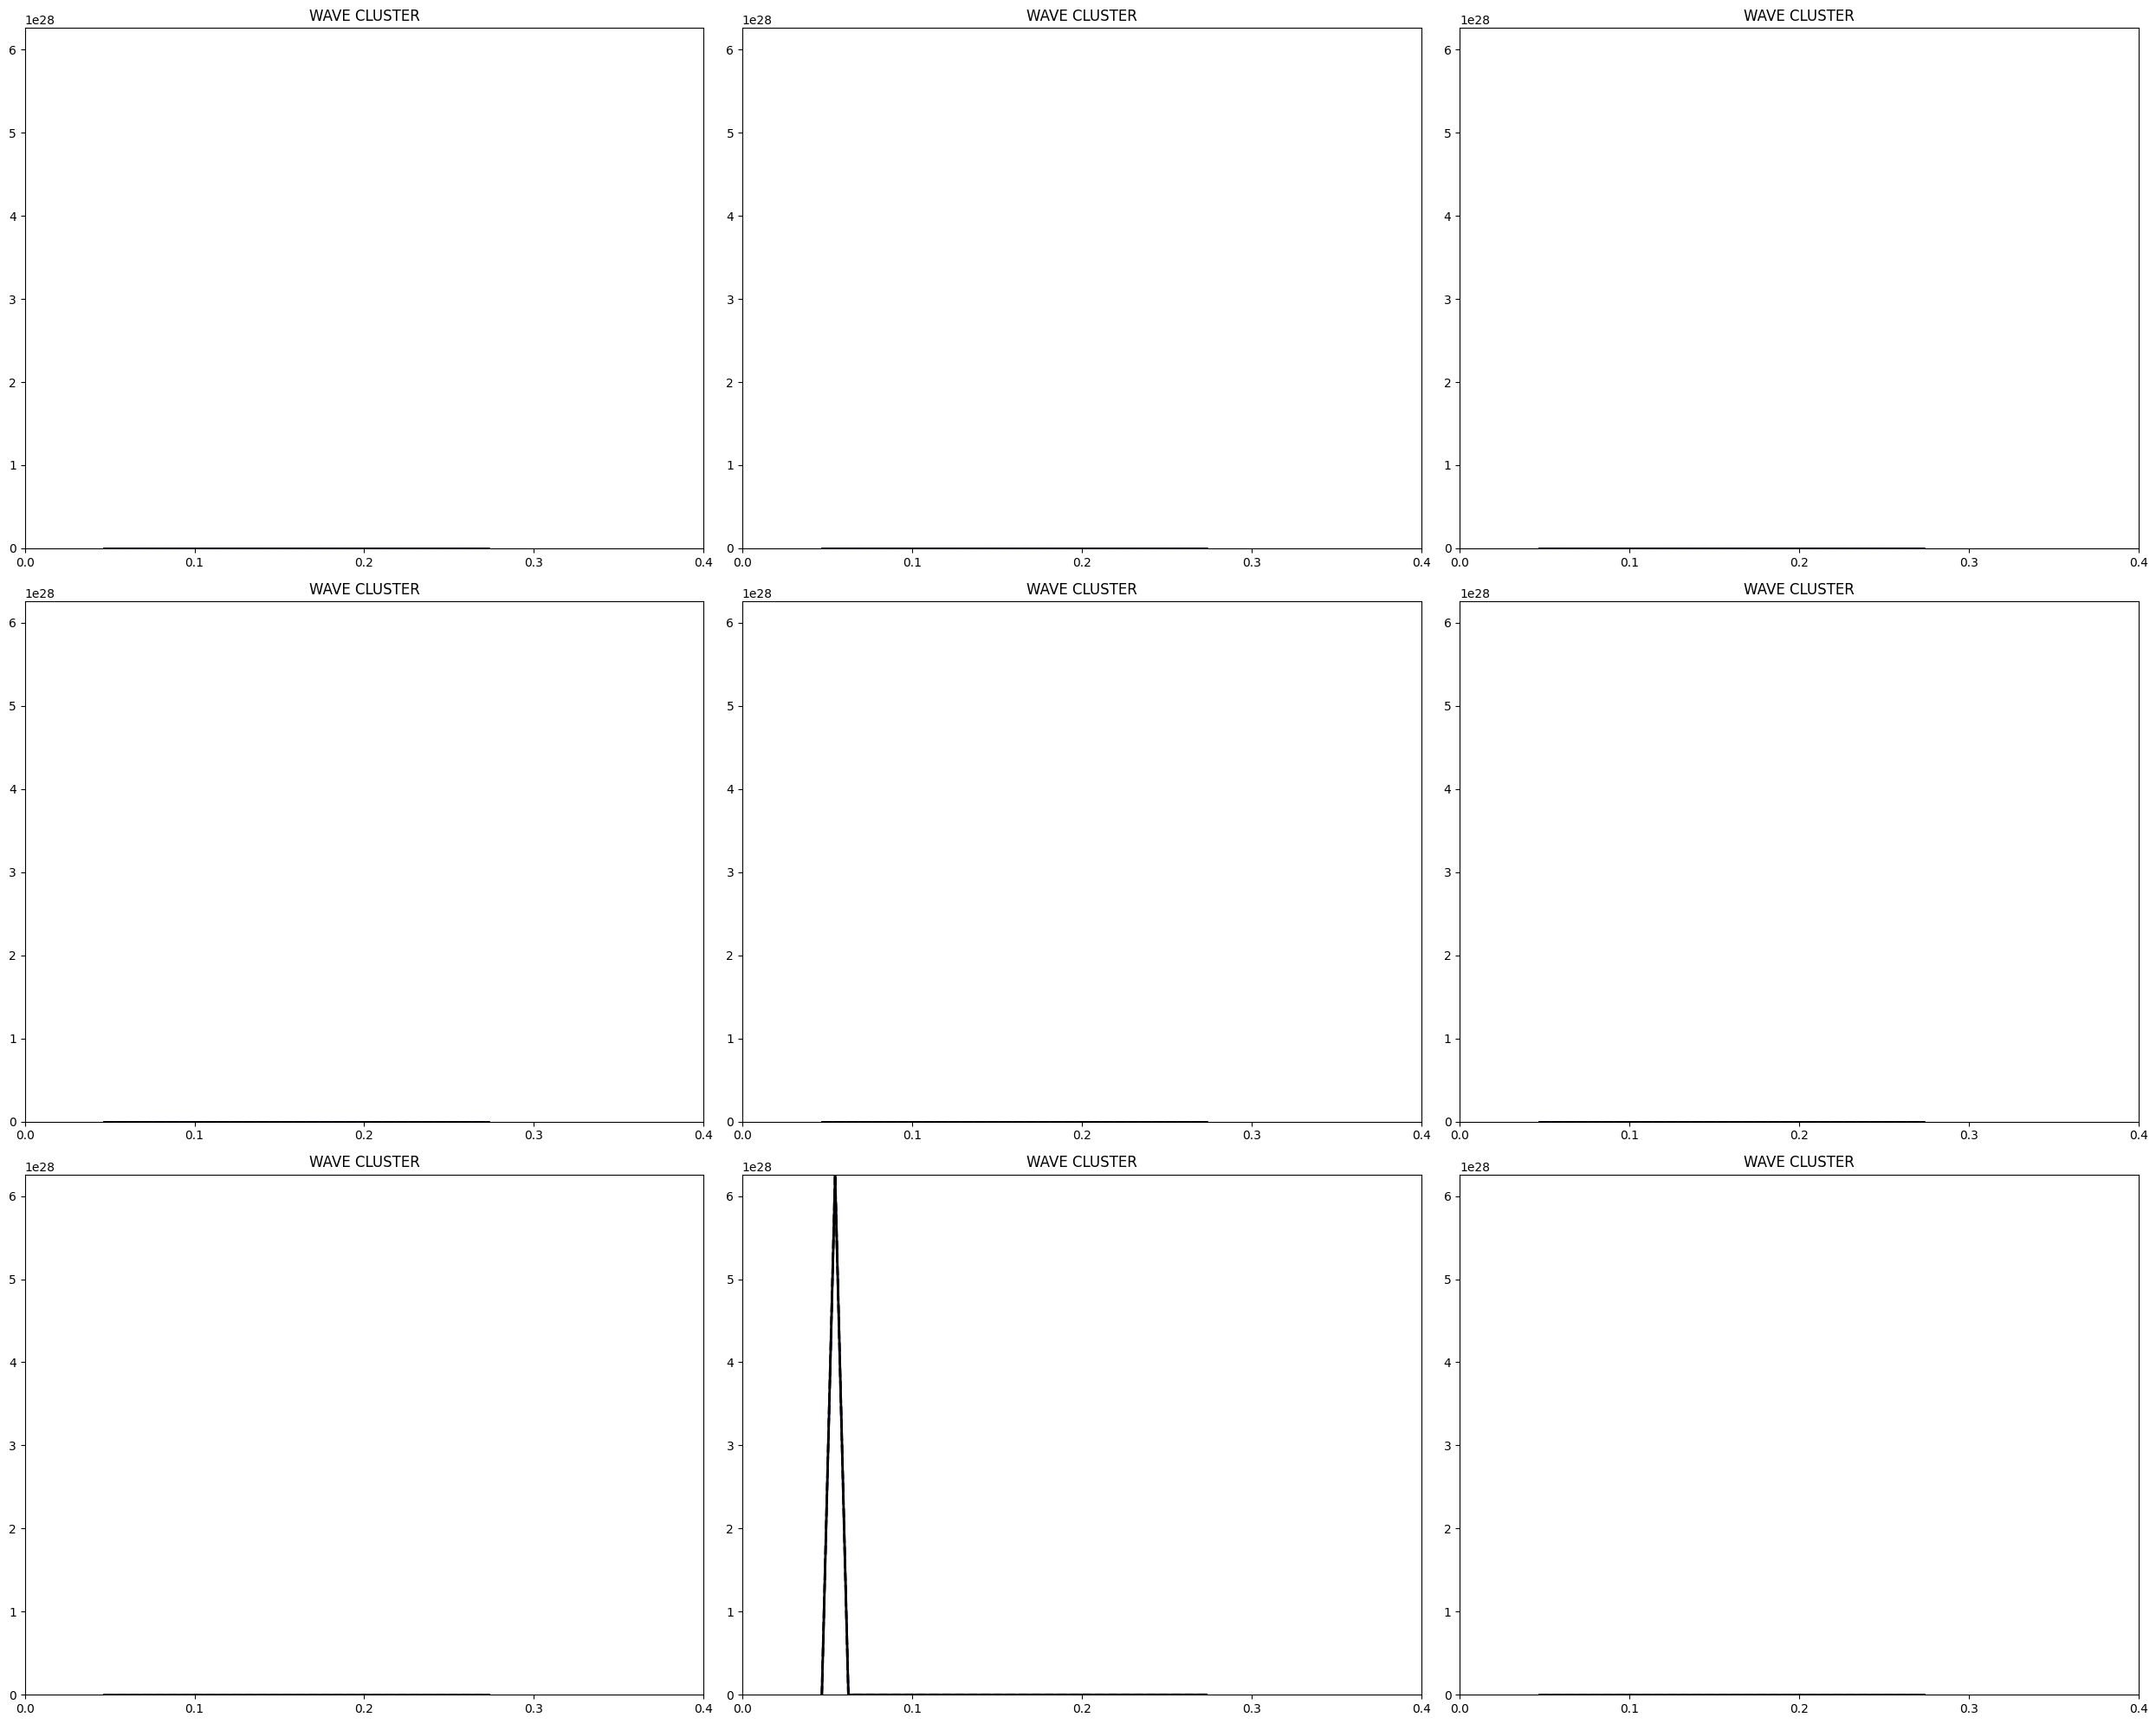

In [35]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly_log(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Torbay 13

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


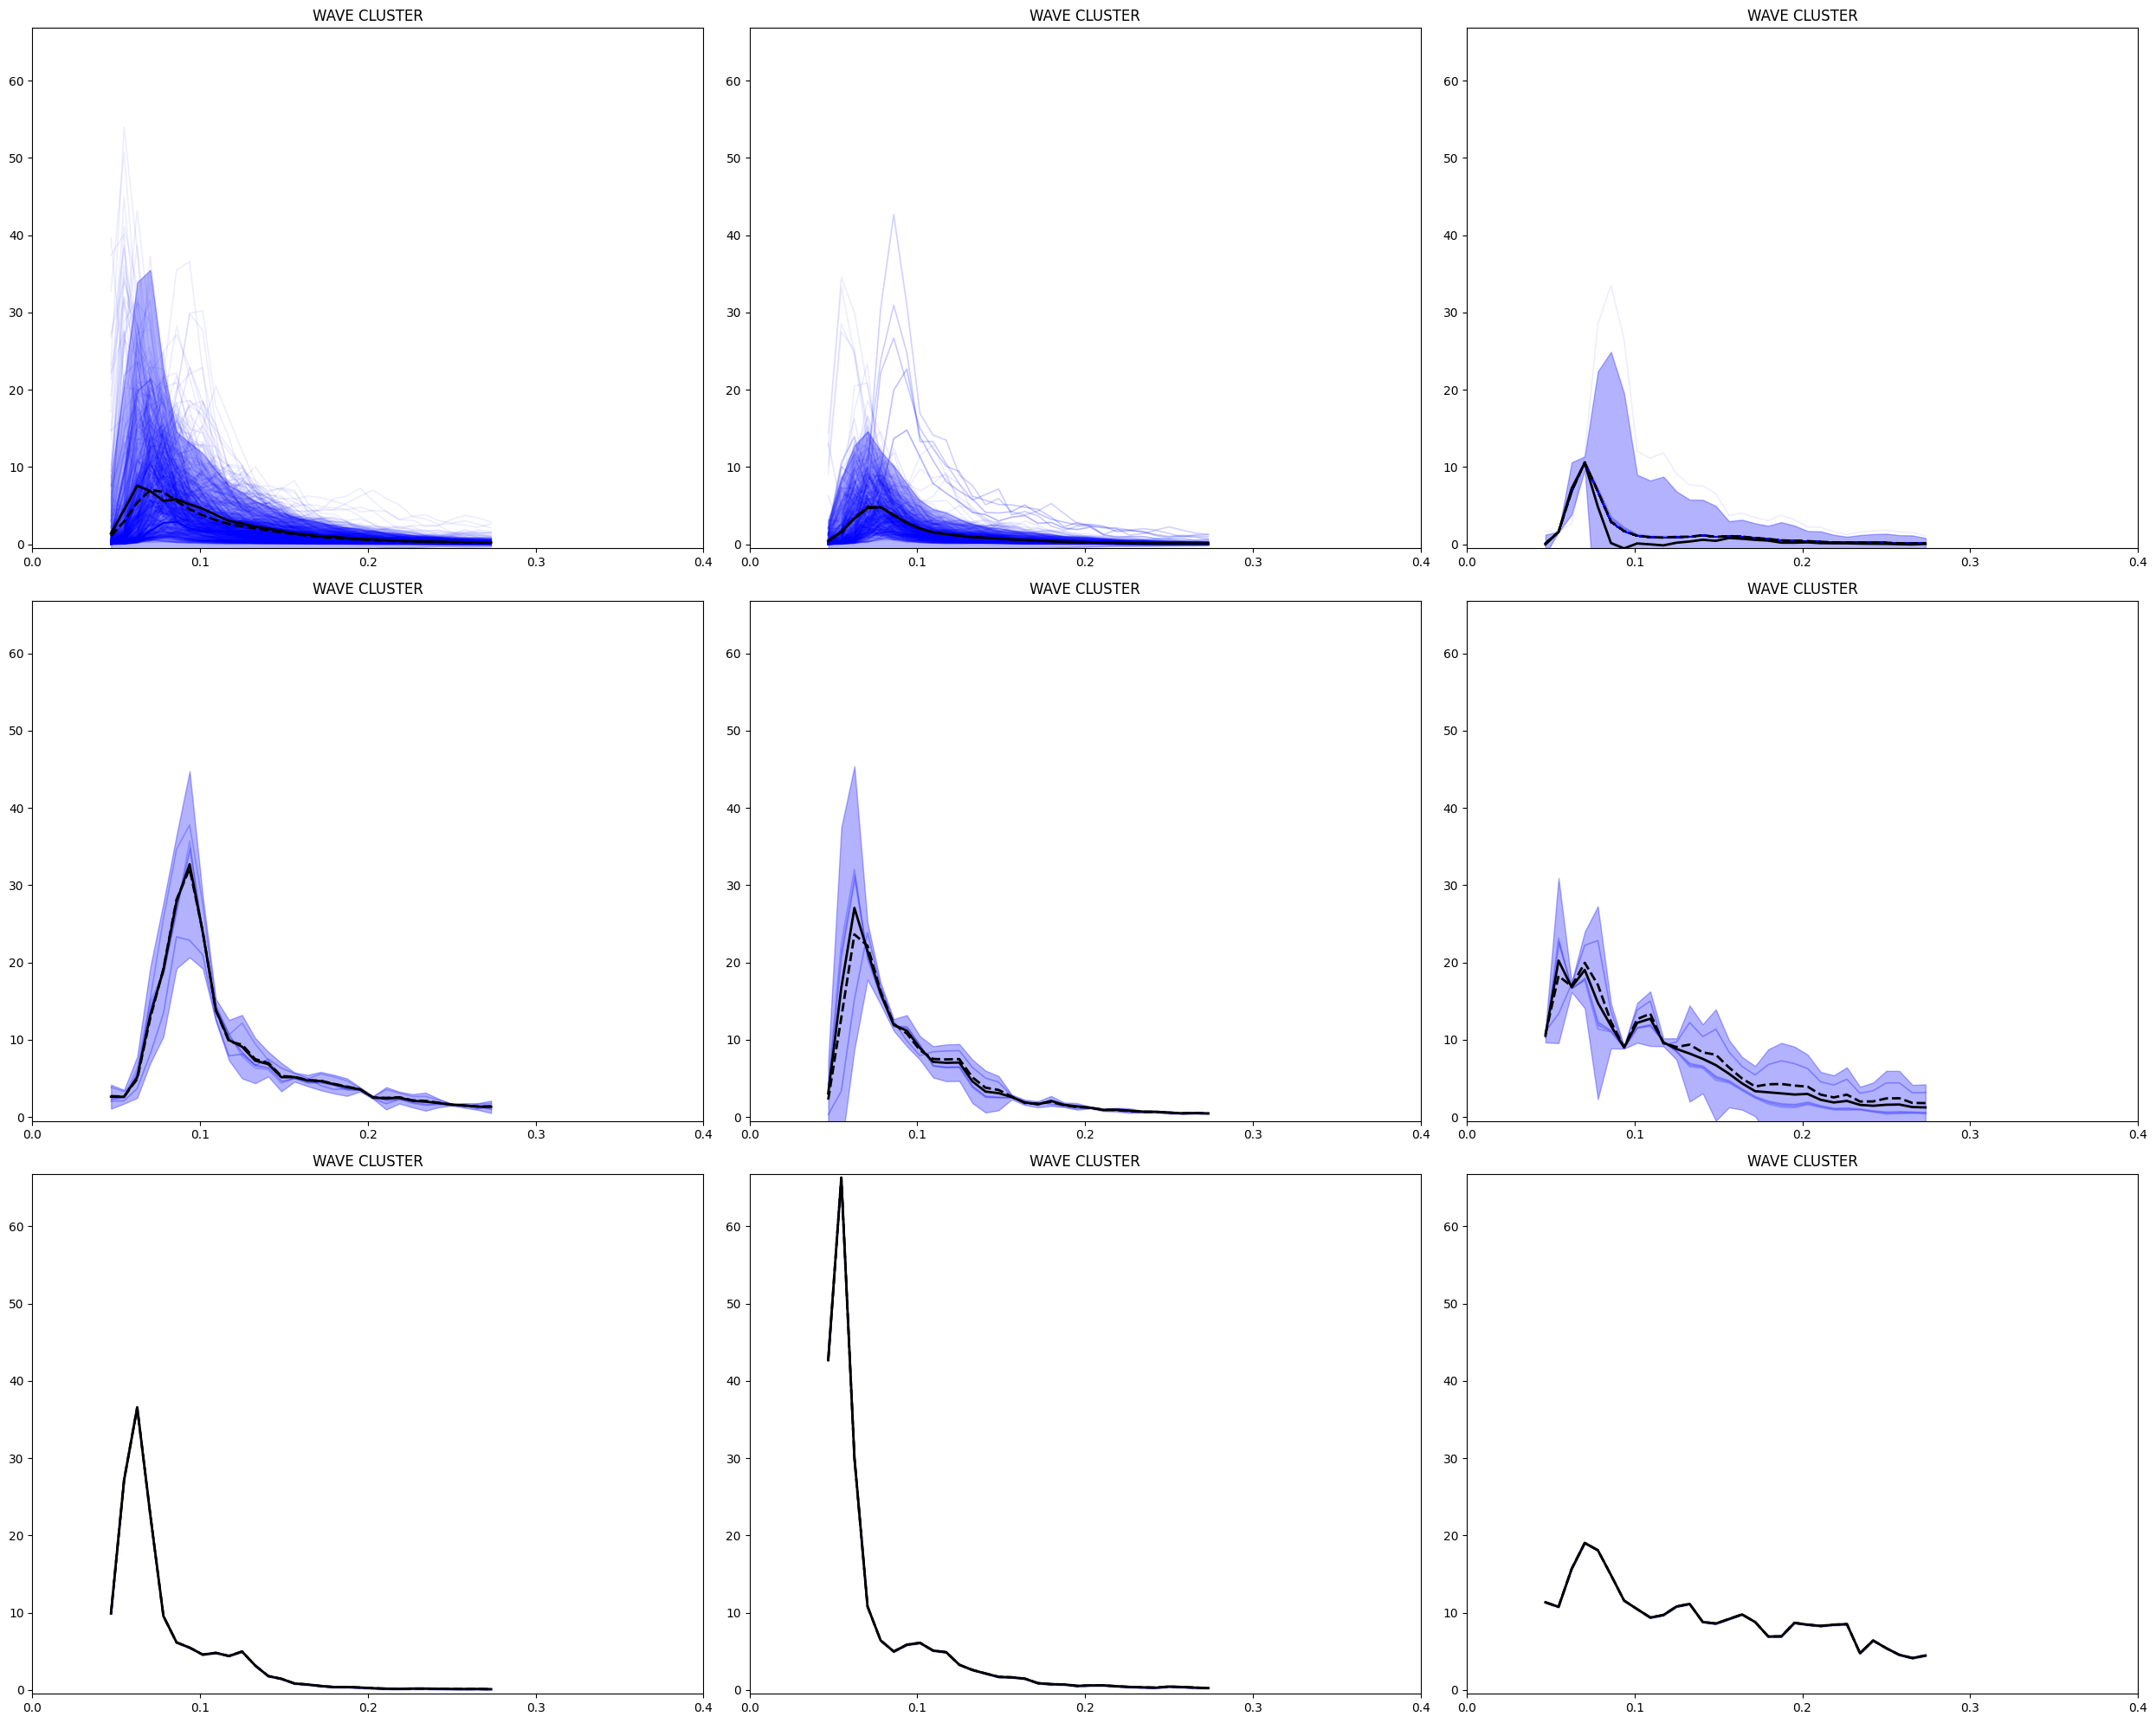

In [36]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Torbay 17 clusters

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


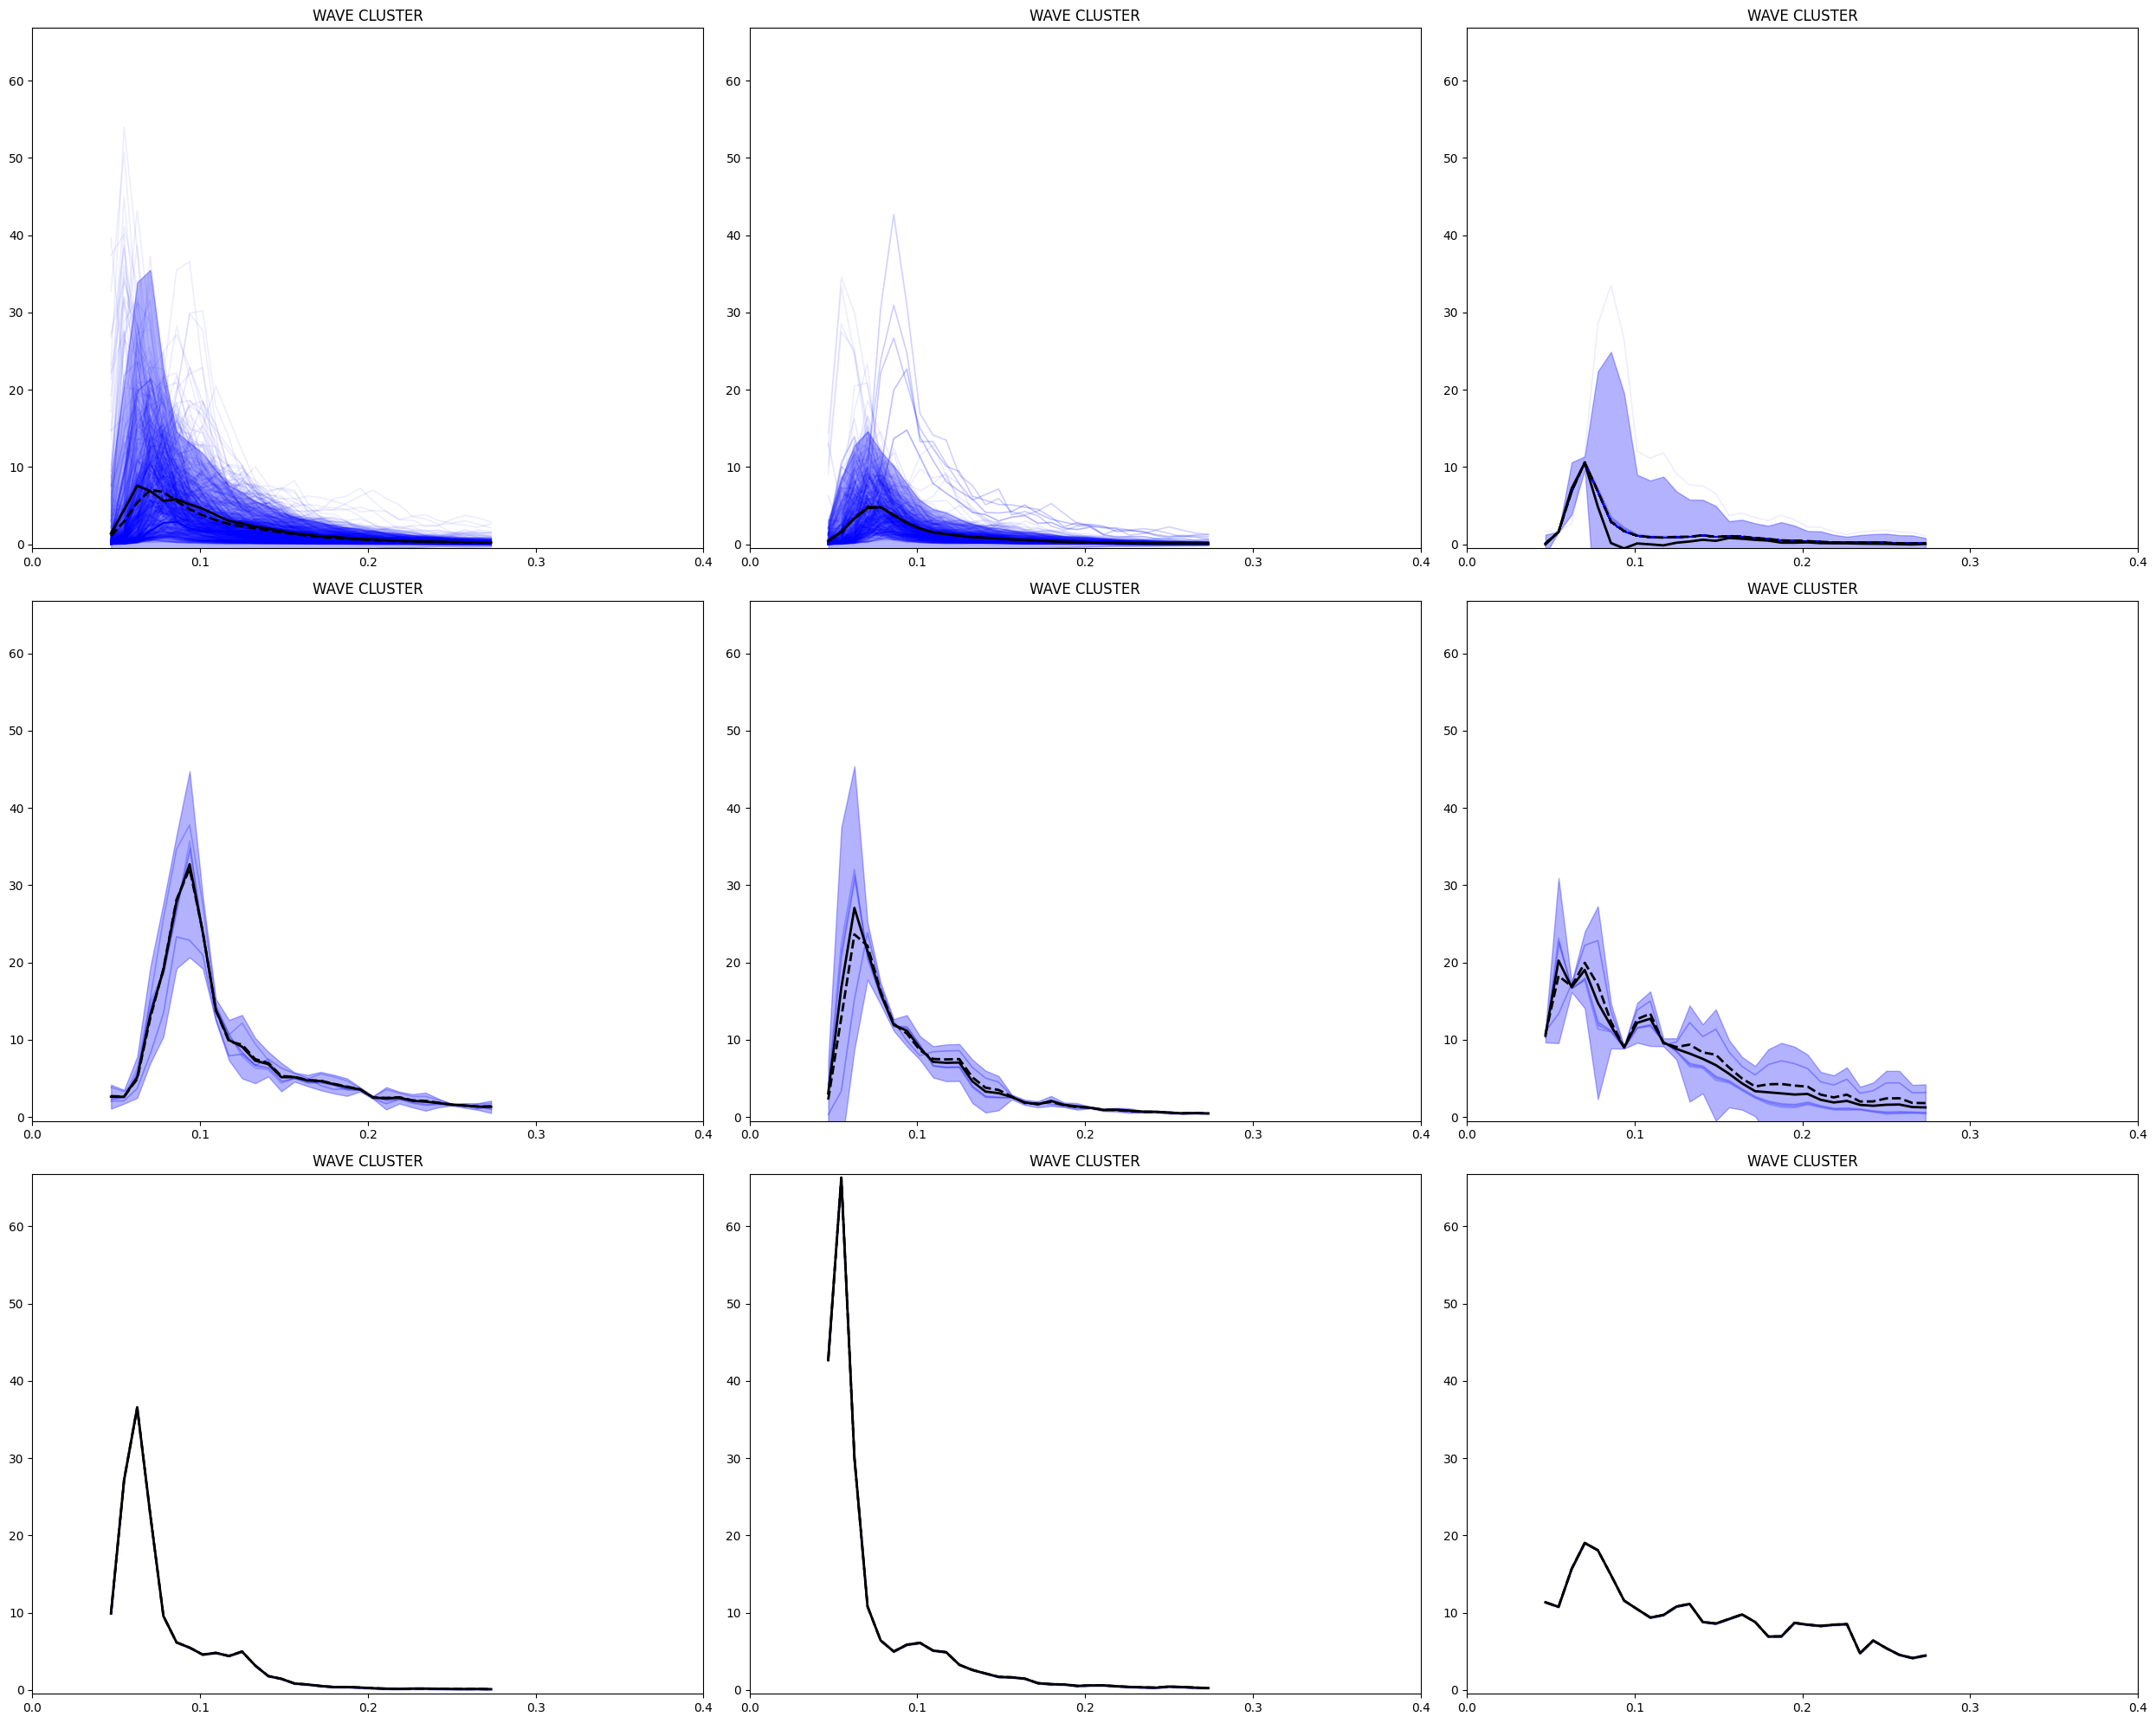

In [37]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

### Torbay 14

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


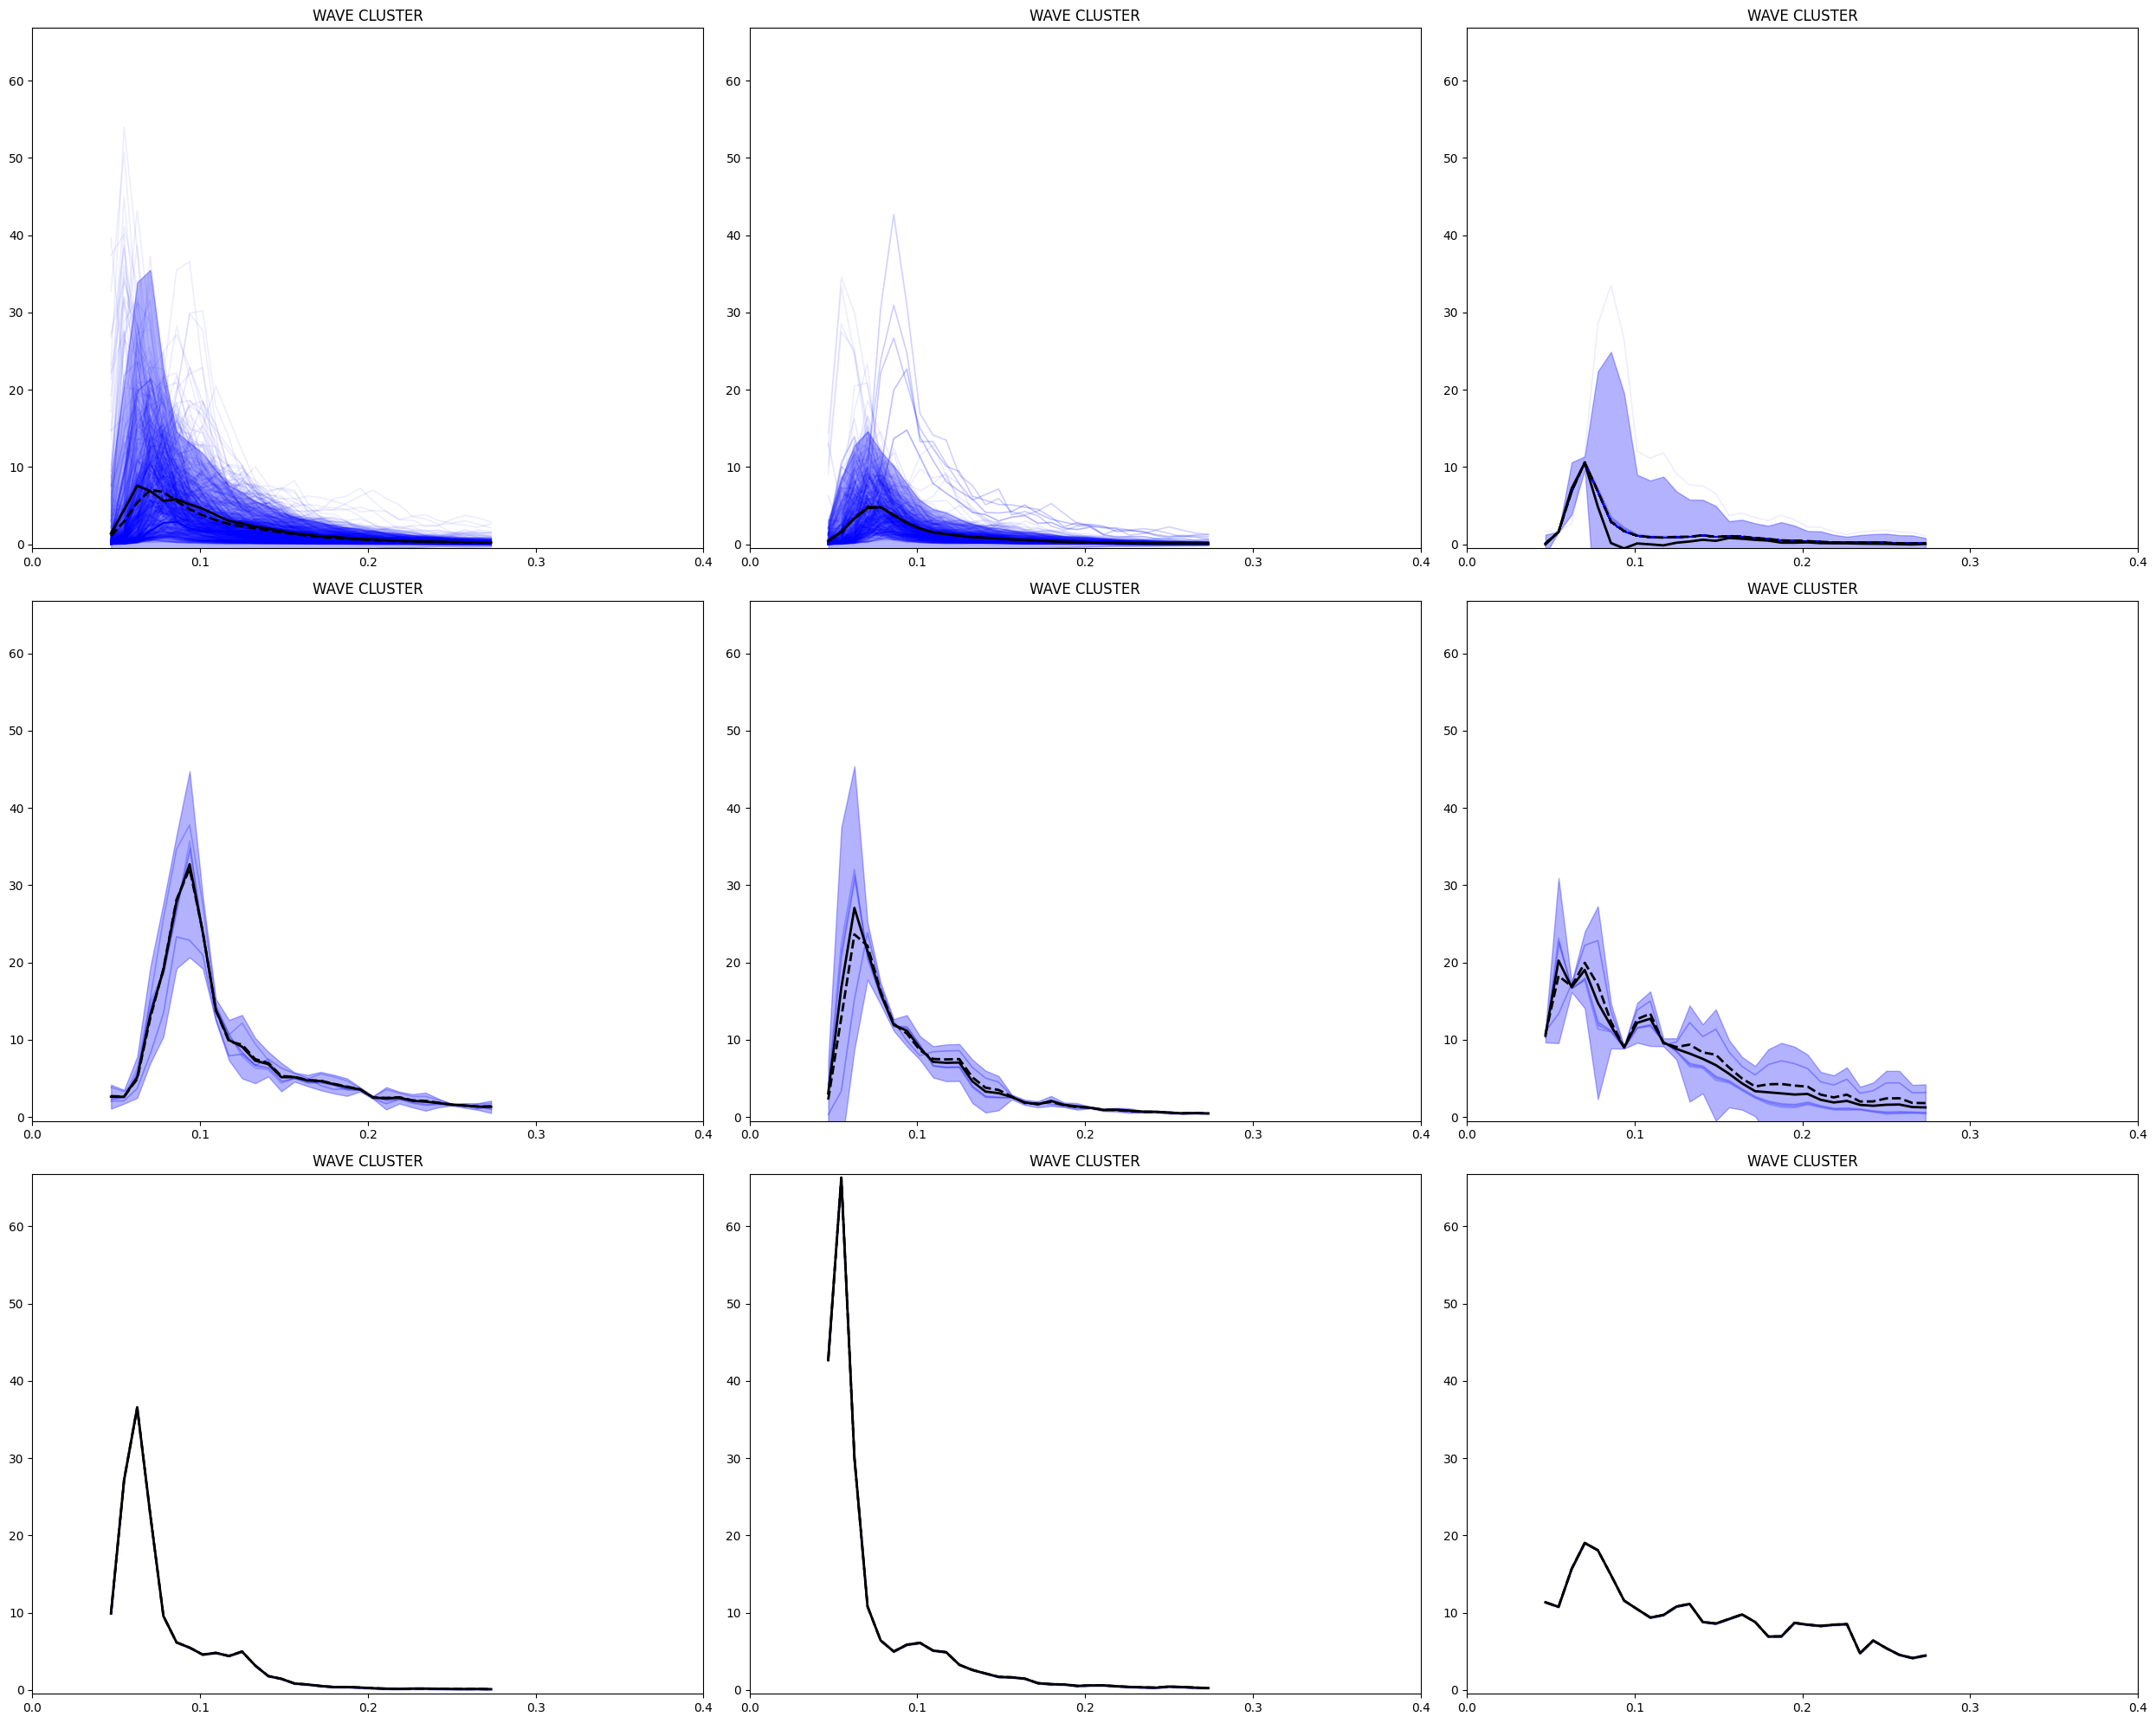

In [38]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

Model 1 : MainModel: N : [N-682]
Model 2 : MainModel: N : [N-471]
Model 3 : MainModel: N : [N-437]
Model 4 : MainModel: N : [N-3]
Model 5 : MainModel: N : [N-2]
Model 6 : MainModel: N : [N-2]
Model 7 : MainModel: N : [N-1]
Model 8 : MainModel: N : [N-1]
Model 9 : MainModel: N : [N-1]
Classification error: 0 / 1600 -- 0.00000


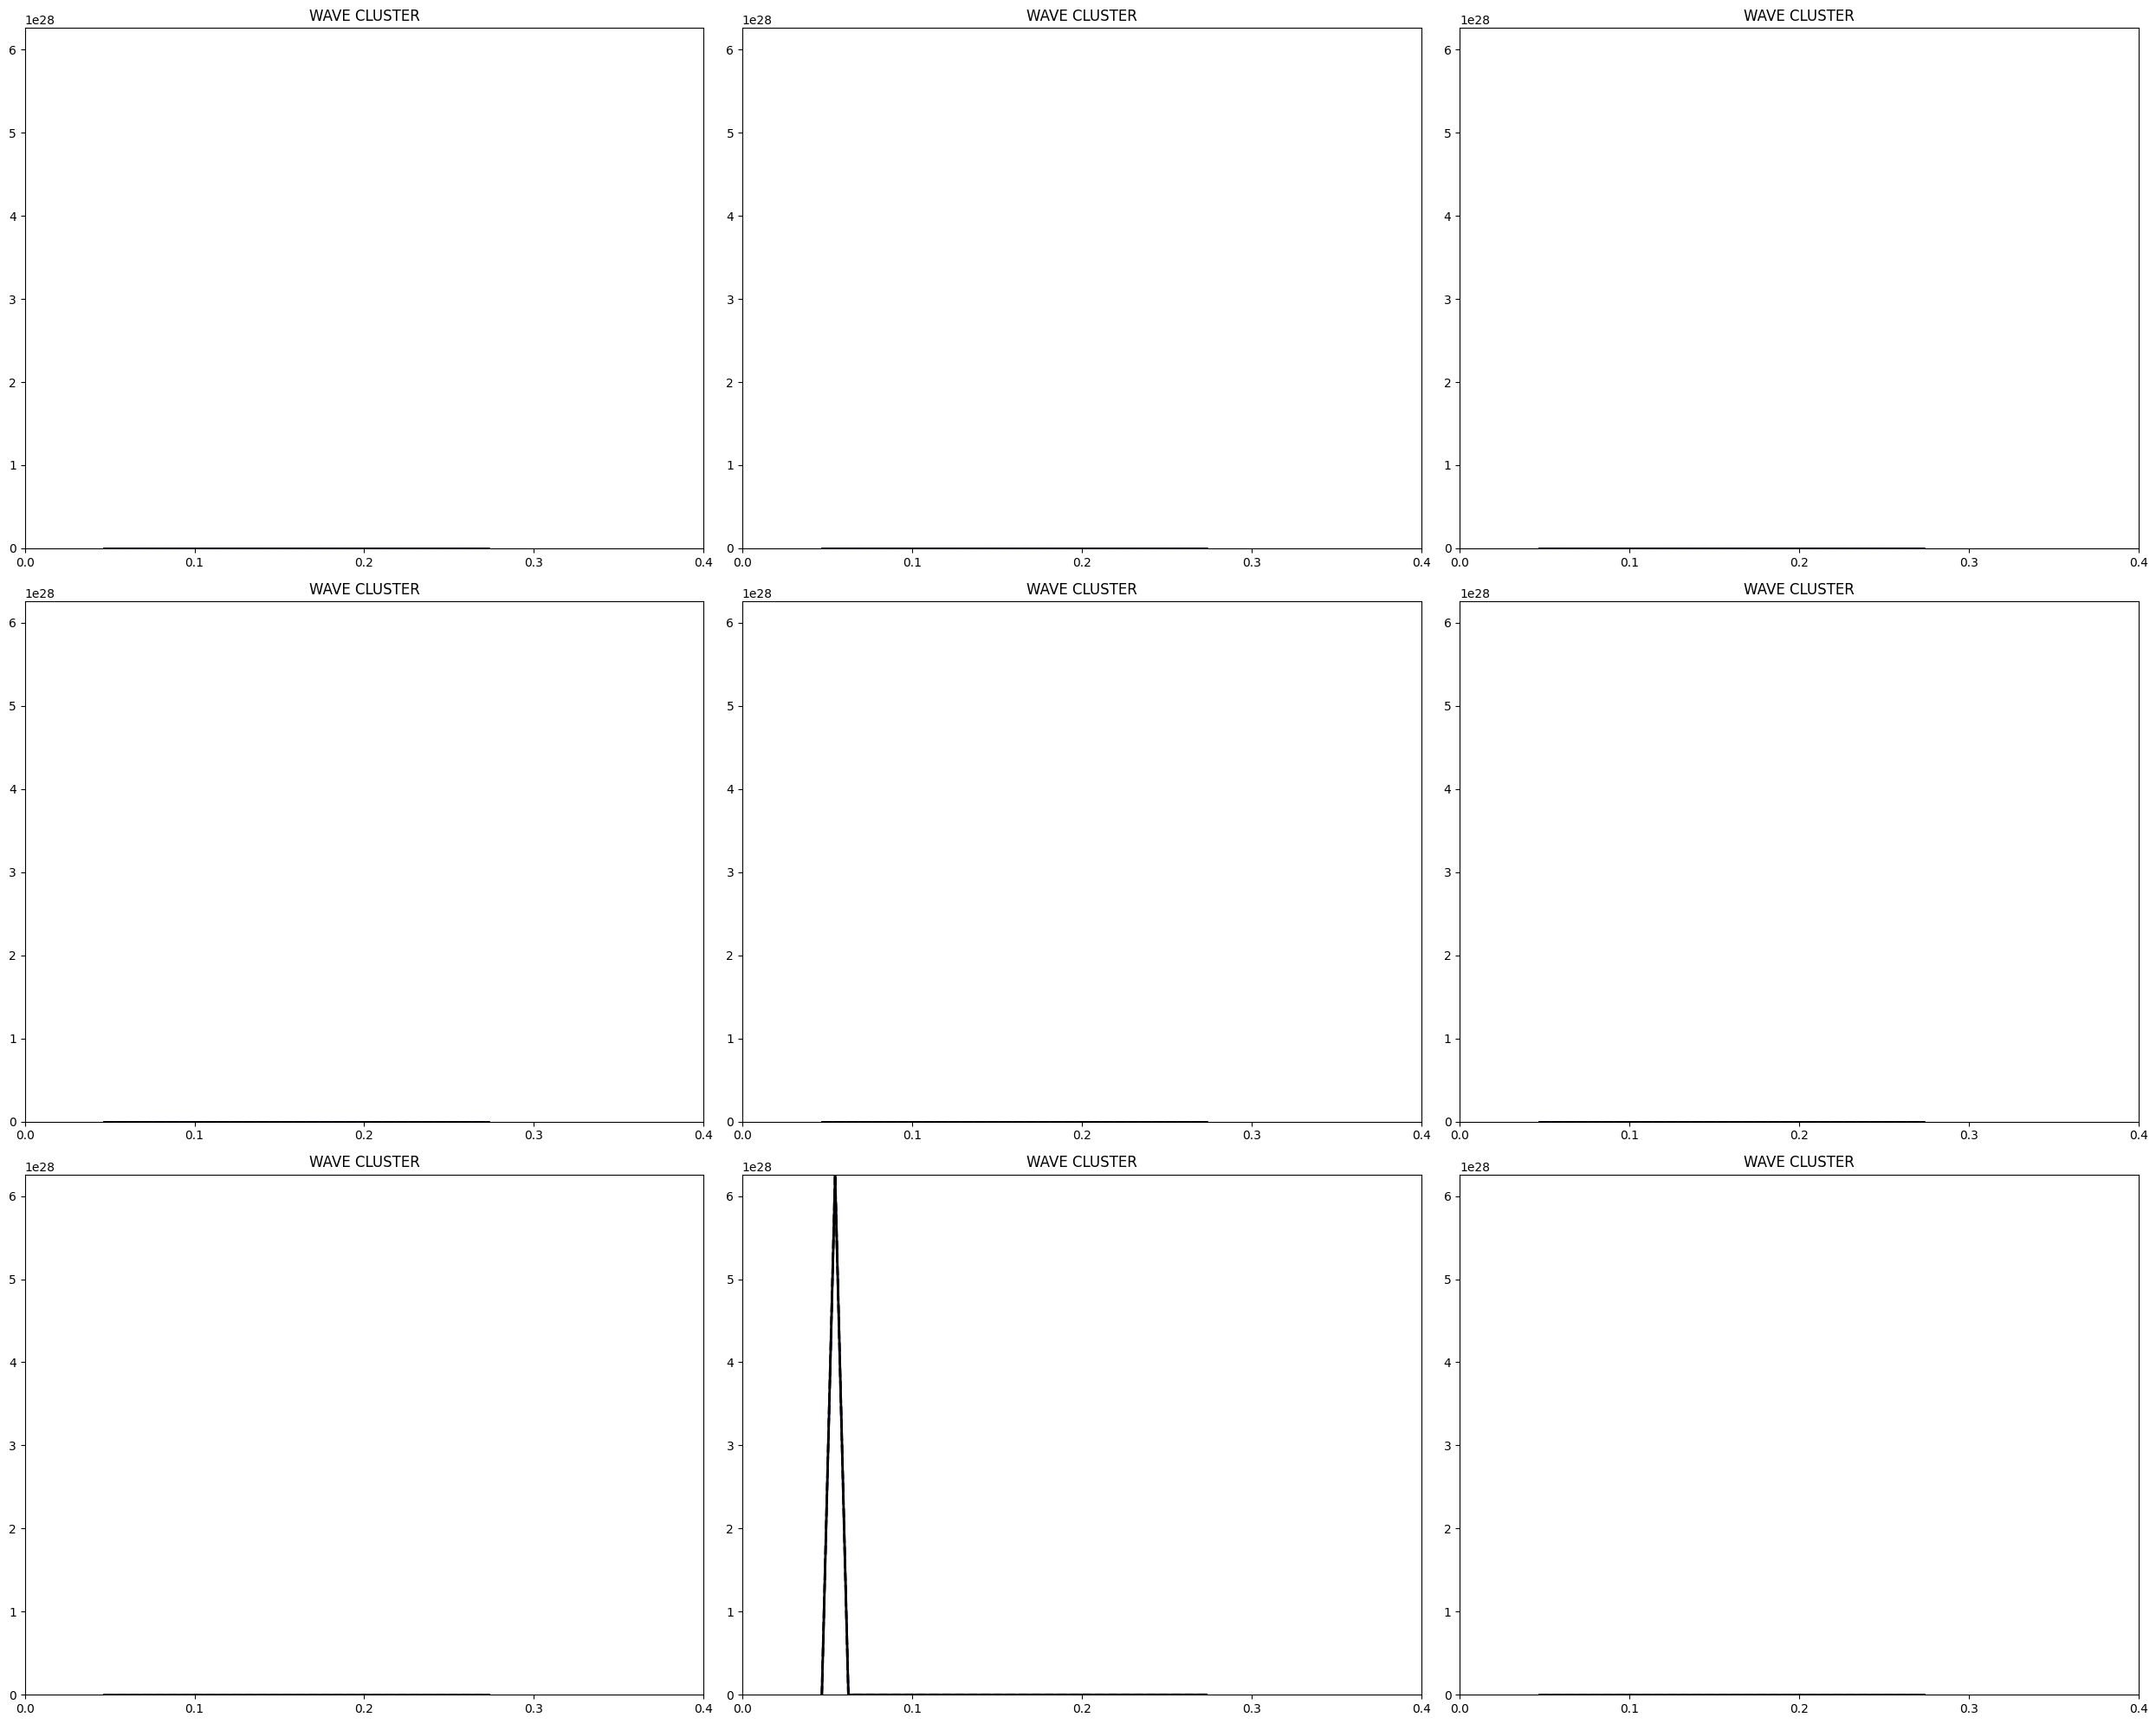

In [39]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly_log(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

### Clasificación con CLARA

In [40]:
data_df = pd.DataFrame(np.squeeze(data[:, 0:len(freq), :], axis=-1))

### 10 clusters

In [41]:
nc = 15
clara = CLARA(n_clusters=nc, random_state=42, max_iter=10000)
clara.fit(data_df)

labels = clara.labels_
centroids = clara.cluster_centers_
n_clusters = clara.n_clusters

num_cols = int(np.ceil(np.sqrt(nc)))
num_rows = int(np.ceil(nc / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
axes = axes.flatten()

for cluster_num in range(n_clusters):
    
    cluster_points = data_df[labels == cluster_num]
    ax = axes[cluster_num]
    

    for row in cluster_points.values:
        ax.plot(freq, row, color='darkorange', alpha=0.1)
    
    ax.plot(freq, centroids[cluster_num, :], color='black', linewidth=2, label=f'Centroide Cluster {cluster_num}')
    num_ondas = cluster_points.shape[0]
    ax.set_title(f'Cluster {cluster_num} - {num_ondas}')
    

for ax in fig.get_axes():
            ax.set_ylim(np.min(data_df)-0.5, np.max(data_df) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))

plt.tight_layout()
plt.show()

NameError: name 'CLARA' is not defined